In [11]:
# db connection

import pymysql
from sqlalchemy import create_engine
import keyring
import platform
import numpy as np

user = 'root'
pw = keyring.get_password('macmini_db', user)
host = '192.168.219.106' if platform.system() == 'Windows' else '127.0.0.1'
port = 3306
db = 'stock'

# DATA COLUMNS

In [12]:
# base data
COLUMNS_STOCK_DATA = ['date', 'open', 'high', 'low', 'close', 'volume']
COLUMNS_TRAINING_DATA = ['open', 'high', 'low', 'close', 'volume', 'close_ma5', 'volume_ma5', 'close_ma5_ratio', 'volume_ma5_ratio',
       'open_close_ratio', 'open_prev_close_ratio', 'high_close_ratio',
       'low_close_ratio', 'close_prev_close_ratio', 'volume_prev_volume_ratio',
       'close_ma10', 'volume_ma10', 'close_ma10_ratio', 'volume_ma10_ratio',
       'close_ma20', 'volume_ma20', 'close_ma20_ratio', 'volume_ma20_ratio',
       'close_ma60', 'volume_ma60', 'close_ma60_ratio', 'volume_ma60_ratio',
       'close_ma120', 'volume_ma120', 'close_ma120_ratio',
       'volume_ma120_ratio', 'close_ma240', 'volume_ma240',
       'close_ma240_ratio', 'volume_ma240_ratio', 'upper_bb',
       'lower_bb', 'bb_pb', 'bb_width', 'macd',
       'macd_signal', 'macd_oscillator', 'rs', 'rsi']

# DEVICE

In [13]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# UTILITIES

## Load Data

### Get stock price

In [14]:
# get stock price
import pandas as pd
import pymysql
from sqlalchemy import create_engine


# get us stock price of a specific ticker
def get_stock_data(ticker, fro=None, to=None, market='global'):
    
    if market == 'global':

        # connect DB
        engine = create_engine(f'mysql+pymysql://{user}:{pw}@{host}:{port}/{db}')

        con = pymysql.connect(
            user=user,
            passwd=pw,
            host=host,
            db=db,
            charset='utf8'
        )
            
        mycursor = con.cursor()
    
        if fro is not None:
            if to is not None:               
                query = f""" 
                        SELECT * FROM price_global
                        WHERE ticker = '{ticker}'
                        AND date BETWEEN '{fro}' AND '{to}' 
                        """
            else:
                query = f""" 
                        SELECT * FROM price_global
                        WHERE ticker = '{ticker}'
                        AND date >= '{fro}'
                        """
        
        else:
            if to is not None:
                query = f""" 
                        SELECT * FROM price_global
                        WHERE ticker = '{ticker}'
                        AND date <= '{to}' 
                        """
            else:
                query = f""" 
                        SELECT * FROM price_global
                        WHERE ticker = '{ticker}'
                        """
                
        print(query)
        stock_data = pd.read_sql(query, con=engine)
        con.close()
        engine.dispose()
        return stock_data[['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'ticker']]
    
    elif market == 'kr':
        # connect DB
        engine = create_engine(f'mysql+pymysql://{user}:{pw}@{host}:{port}/{db}')

        con = pymysql.connect(
            user=user,
            passwd=pw,
            host=host,
            db=db,
            charset='utf8'
        )
        
        if fro is not None:
            if to is not None:               
                query = f""" 
                        SELECT * FROM price_kr
                        WHERE company_code = '{ticker}'
                        AND date BETWEEN '{fro}' AND '{to}' 
                        """
            else:
                query = f""" 
                        SELECT * FROM price_kr
                        WHERE company_code = '{ticker}'
                        AND date >= '{fro}'
                        """
                        
        else:
            if to is not None:
                query = f""" 
                        SELECT * FROM price_kr
                        WHERE company_code = '{ticker}'
                        AND date <= '{to}' 
                        """
            else:
                query = f""" 
                        SELECT * FROM price_kr
                        WHERE company_code = '{ticker}'
                        """
                        
        print(query)
        stock_data = pd.read_sql(query, con=engine)
        stock_data.rename(columns={'company_code':'ticker'}, inplace=True)
        con.close()
        engine.dispose()
        return stock_data[['date', 'open', 'high', 'low', 'close', 'volume', 'ticker']]
        
    else:
        print(f'No market like {market}')

#### Sample code

In [29]:
stock_code = '005930'
stock_name = '삼성전자'
fro = '2018-01-01'
to = '2022-12-31'
market = 'kr'
df = get_stock_data(stock_code, fro=fro, to=to, market=market)

 
                        SELECT * FROM price_kr
                        WHERE company_code = '005930'
                        AND date BETWEEN '2018-01-01' AND '2022-12-31' 
                        


In [30]:
df

,date,open,high,low,close,volume,ticker
0,2018-01-02,51380.0,51400.0,50780.0,51020.0,169485.0,005930
1,2018-01-03,52540.0,52560.0,51420.0,51620.0,200270.0,005930
2,2018-01-04,52120.0,52180.0,50640.0,51080.0,233909.0,005930
3,2018-01-05,51300.0,52120.0,51200.0,52120.0,189623.0,005930
4,2018-01-08,52400.0,52520.0,51500.0,52020.0,167673.0,005930
...,...,...,...,...,...,...,...
1227,2022-12-23,58200.0,58400.0,57700.0,58100.0,9829407.0,005930
1228,2022-12-26,58000.0,58100.0,57700.0,57900.0,6756411.0,005930
1229,2022-12-27,58000.0,58400.0,57900.0,58100.0,10667027.0,005930
1230,2022-12-28,57600.0,57600.0,56400.0,56600.0,14665410.0,005930


### Preprocessing

In [31]:
# preprocessing

def preprocess(data):
    
    # moving average
    windows = [5, 10, 20, 60, 120, 240]
    for window in windows:
        data[f'close_ma{window}'] = data['close'].rolling(window).mean()
        data[f'volume_ma{window}'] = data['volume'].rolling(window).mean()
        data[f'close_ma{window}_ratio'] = (data['close'] - data[f'close_ma{window}']) / data[f'close_ma{window}']
        data[f'volume_ma{window}_ratio'] = (data['volume'] - data[f'volume_ma{window}']) / data[f'volume_ma{window}']
        data['open_close_ratio'] = (data['open'].values - data['close'].values) / data['close'].values
        data['open_prev_close_ratio'] = np.zeros(len(data))
        data.loc[1:, 'open_prev_close_ratio'] = (data['open'][1:].values - data['close'][:-1].values) / data['close'][:-1].values
        data['high_close_ratio'] = (data['high'].values - data['close'].values) / data['close'].values
        data['low_close_ratio'] = (data['low'].values - data['close'].values) / data['close'].values
        data['close_prev_close_ratio'] = np.zeros(len(data))
        data.loc[1:, 'close_prev_close_ratio'] = (data['close'][1:].values - data['close'][:-1].values) / data['close'][:-1].values 
        data['volume_prev_volume_ratio'] = np.zeros(len(data))
        data.loc[1:, 'volume_prev_volume_ratio'] = (
            # if volume is 0, change it into non zero value exploring previous volume continuously
            (data['volume'][1:].values - data['volume'][:-1].values) / data['volume'][:-1].replace(to_replace=0, method='ffill').replace(to_replace=0, method='bfill').values
        )
    
    # Bollinger band
    data['middle_bb'] = data['close'].rolling(20).mean()
    data['upper_bb'] = data['middle_bb'] + 2 * data['close'].rolling(20).std()
    data['lower_bb'] = data['middle_bb'] - 2 * data['close'].rolling(20).std()
    data['bb_pb'] = (data['close'] - data['lower_bb']) / (data['upper_bb'] - data['lower_bb'])
    data['bb_width'] = (data['upper_bb'] - data['lower_bb']) / data['middle_bb']
    
    # MACD
    macd_short, macd_long, macd_signal = 12, 26, 9
    data['ema_short'] = data['close'].ewm(macd_short).mean()
    data['ema_long'] = data['close'].ewm(macd_long).mean()
    data['macd'] = data['ema_short'] - data['ema_long']
    data['macd_signal'] = data['macd'].ewm(macd_signal).mean()
    data['macd_oscillator'] = data['macd'] - data['macd_signal']
    
    # RSI
    data['close_change'] = data['close'].diff()
    # data['close_up'] = np.where(data['close_change'] >=0, df['close_change'], 0)
    data['close_up'] = data['close_change'].apply(lambda x: x if x >= 0 else 0)
    # data['close_down'] = np.where(data['close_change'] < 0, df['close_change'].abs(), 0)
    data['close_down'] = data['close_change'].apply(lambda x: -x if x < 0 else 0)
    data['rs'] = data['close_up'].ewm(alpha=1/14, min_periods=14).mean() / data['close_down'].ewm(alpha=1/14, min_periods=14).mean()
    data['rsi'] = 100 - (100 / (1 + data['rs']))
    
    
    return data

#### Sample code

In [32]:
df_adj = preprocess(df)

### Load data function

load_data() function is a combined function for getting data from databases and preprocessing it into training data.

In [44]:
def load_data(stock_code, fro, to, market='global'):
    ''' 
    Arguments
    ----------
    - stock_code : unique stock code
    - fro : start date
    - to : end data
    
    Returns
    --------
    df_adj : entire prerprocessed data
    stock_data : data for plotting chart
    training_data : data for training a model
    '''
    
    df = get_stock_data(stock_code, fro, to, market)
    df_adj = preprocess(df).dropna().reset_index(drop=True)
    # df_adj.dropna(inplace=True).reset_index(drop=True)
    
    stock_data = df_adj[COLUMNS_STOCK_DATA]
    training_data = df_adj[COLUMNS_TRAINING_DATA]
    
    return df_adj, stock_data, training_data.values

#### Sample code

In [45]:
df_adj, df_stock_data, df_training_data = load_data(stock_code, fro, to, market)

 
                        SELECT * FROM price_kr
                        WHERE company_code = '005930'
                        AND date BETWEEN '2018-01-01' AND '2022-12-31' 
                        


## Functions

### Sigmoid function

- function for calculating probabilities based on the value

In [46]:
def sigmoid(x):
    x = max(min(x, 10), -10)
    return 1. / (1. + np.exp(-x))

In [47]:
df

,date,open,high,low,close,volume,ticker,close_ma5,volume_ma5,close_ma5_ratio,...,ema_short,ema_long,macd,macd_signal,macd_oscillator,close_change,close_up,close_down,rs,rsi
0,2018-01-02,51380.0,51400.0,50780.0,51020.0,169485.0,005930,NaN,NaN,NaN,...,51020.000000,51020.000000,0.000000,0.000000,0.000000,NaN,0.0,0.0,NaN,NaN
1,2018-01-03,52540.0,52560.0,51420.0,51620.0,200270.0,005930,NaN,NaN,NaN,...,51332.000000,51325.660377,6.339623,3.336643,3.002979,600.0,600.0,0.0,NaN,NaN
2,2018-01-04,52120.0,52180.0,50640.0,51080.0,233909.0,005930,NaN,NaN,NaN,...,51241.194030,51240.664452,0.529578,2.300826,-1.771248,-540.0,0.0,540.0,NaN,NaN
3,2018-01-05,51300.0,52120.0,51200.0,52120.0,189623.0,005930,NaN,NaN,NaN,...,51487.933546,51473.095280,14.838267,5.946491,8.891776,1040.0,1040.0,0.0,NaN,NaN
4,2018-01-08,52400.0,52520.0,51500.0,52020.0,167673.0,005930,51572.0,192192.0,0.008687,...,51612.024890,51590.884110,21.140779,9.656849,11.483930,-100.0,0.0,100.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,2022-12-23,58200.0,58400.0,57700.0,58100.0,9829407.0,005930,58660.0,9577591.2,-0.009547,...,59604.352833,59485.208687,119.144145,459.081100,-339.936955,-1000.0,0.0,1000.0,0.731008,42.230205
1228,2022-12-26,58000.0,58100.0,57700.0,57900.0,6756411.0,005930,58340.0,9389636.0,-0.007542,...,59473.248769,59426.497255,46.751514,417.848141,-371.096627,-200.0,0.0,200.0,0.705995,41.383167
1229,2022-12-27,58000.0,58400.0,57900.0,58100.0,10667027.0,005930,58240.0,9666089.2,-0.002404,...,59367.614248,59377.367727,-9.753479,375.087979,-384.841458,200.0,200.0,0.0,0.742845,42.622550
1230,2022-12-28,57600.0,57600.0,56400.0,56600.0,14665410.0,005930,57960.0,10527777.0,-0.023464,...,59154.720844,59274.502255,-119.781411,325.601040,-445.382451,-1500.0,0.0,1500.0,0.572459,36.405353


# ENVIRONMENTS

- Environment has stock market data and return the current and next price to the agent/

In [48]:
# environment

import numpy as np
import pandas as pd

# environment

class Environment:
    ''' 
    Attribute
    ---------
    - stock_data : stock price data such as 'open', 'close', 'high', 'low', 'volume'
    - state : current state
    - idx : current postion of stock data
    
    
    Functions
    --------
    - reset() : initialize idx and state
    - observe() : move idx into next postion and get a new state
    - get_close_price() : get close price of current state
    - get_next_close_price() : get close price of next index state
    - get_open_price() : get open price of current state
    - get_next_open_price() : get open price of next indext state
    - get_state() : get current state
    '''
    
    def __init__(self, stock_data=None):
        self.close_price_idx = 4    # index postion of close price
        self.open_price_idx = 1     # index position of open price
        self.stock_data = stock_data
        self.state = None
        self.idx = -1
        # self.max_idx = len(self.stock_data)
        
    def reset(self):
        self.state = None
        self.idx = -1
        # self.idx = 0
        # self.state = self.stock_data.iloc[self.idx]
        
    def observe(self):
        # move to next day and get price data
        # if there is no more idx, return None
        if len(self.stock_data) > self.idx + 1:
            self.idx += 1
            self.state = self.stock_data.iloc[self.idx]
            return self.state
        return None
    
    def get_close_price(self):
        # return close price
        if self.state is not None:
            return self.state[self.close_price_idx]
        return None
    
    def get_next_close_price(self):
        # return tomorrow close price
        # if self.idx < self.max_idx - 1:
        #     return self.stock_data.iloc[self.idx + 1, self.close_price_idx]
        # else:
        #     return self.stock_data.iloc[self.idx, self.close_price_idx]
        try:
            return self.stock_data.iloc[self.idx + 1, self.close_price_idx]
        except:
            return self.stock_data.iloc[self.idx, self.close_price_idx]

    
    def get_open_price(self):
        # return open price
        if self.state is not None:
            return self.state[self.open_price_idx]
        
    def get_next_open_price(self):
        # return tomorrow open price
        # if self.idx < self.max_idx - 1:
        #     return self.stock_data.iloc[self.idx + 1, self.open_price_idx]
        # else:
        #     return self.stock_data.iloc[self.idx, self.open_price_idx] 
        # return self.stock_data.iloc[self.idx + 1, self.open_price_idx]
    
        try:
            return self.stock_data.iloc[self.idx + 1, self.open_price_idx]
        except:
            return self.stock_data.iloc[self.idx, self.open_price_idx] 


        
    def get_state(self):
        # return current state
        if self.state is not None:
            return self.state
        return None
        

#### Sample code

In [49]:
e = Environment(df_adj)
e.reset()

In [50]:
e.get_state()

In [51]:
e.observe()

date                             2018-12-21
open                                38200.0
high                                38650.0
low                                 38100.0
close                               38650.0
volume                           14947080.0
ticker                               005930
close_ma5                           38890.0
volume_ma5                       11880360.6
close_ma5_ratio                   -0.006171
volume_ma5_ratio                   0.258134
open_close_ratio                  -0.011643
open_prev_close_ratio             -0.011643
high_close_ratio                        0.0
low_close_ratio                    -0.01423
close_prev_close_ratio                  0.0
volume_prev_volume_ratio           0.252099
close_ma10                          39430.0
volume_ma10                      14288354.0
close_ma10_ratio                  -0.019782
volume_ma10_ratio                  0.046102
close_ma20                          40820.0
volume_ma20                     

In [52]:
e.get_state()

date                             2018-12-21
open                                38200.0
high                                38650.0
low                                 38100.0
close                               38650.0
volume                           14947080.0
ticker                               005930
close_ma5                           38890.0
volume_ma5                       11880360.6
close_ma5_ratio                   -0.006171
volume_ma5_ratio                   0.258134
open_close_ratio                  -0.011643
open_prev_close_ratio             -0.011643
high_close_ratio                        0.0
low_close_ratio                    -0.01423
close_prev_close_ratio                  0.0
volume_prev_volume_ratio           0.252099
close_ma10                          39430.0
volume_ma10                      14288354.0
close_ma10_ratio                  -0.019782
volume_ma10_ratio                  0.046102
close_ma20                          40820.0
volume_ma20                     

In [53]:
e.get_next_close_price()

38800.0

In [54]:
e.observe()

date                             2018-12-24
open                                38500.0
high                                39050.0
low                                 38300.0
close                               38800.0
volume                            9729530.0
ticker                               005930
close_ma5                           38820.0
volume_ma5                       11519673.0
close_ma5_ratio                   -0.000515
volume_ma5_ratio                  -0.155399
open_close_ratio                  -0.007732
open_prev_close_ratio             -0.003881
high_close_ratio                   0.006443
low_close_ratio                   -0.012887
close_prev_close_ratio             0.003881
volume_prev_volume_ratio          -0.349068
close_ma10                          39290.0
volume_ma10                      13772080.7
close_ma10_ratio                  -0.012471
volume_ma10_ratio                 -0.293532
close_ma20                          40630.0
volume_ma20                     

In [55]:
e.get_state()['close']

38800.0

In [56]:
e.get_close_price()

38800.0

In [57]:
e.get_next_open_price()

38400.0

In [58]:
e.observe()

date                             2018-12-26
open                                38400.0
high                                38750.0
low                                 38300.0
close                               38350.0
volume                           12707675.0
ticker                               005930
close_ma5                           38710.0
volume_ma5                       11852787.8
close_ma5_ratio                     -0.0093
volume_ma5_ratio                   0.072125
open_close_ratio                   0.001304
open_prev_close_ratio             -0.010309
high_close_ratio                    0.01043
low_close_ratio                   -0.001304
close_prev_close_ratio            -0.011598
volume_prev_volume_ratio           0.306093
close_ma10                          39100.0
volume_ma10                      13978971.6
close_ma10_ratio                  -0.019182
volume_ma10_ratio                 -0.090943
close_ma20                          40395.0
volume_ma20                     

In [59]:
e.get_state()['open']

38400.0

In [60]:
e.get_open_price()

38400.0

# AGENT



- Agent decides and validates an action accoding to the value of networks from learners class.

- Agent also has initial balance and current portfolio value.

- Agent has its own states : ratio of holding stocks, profit/loss ratio, current current price to average buying price ratio

In [61]:
class Agent:
    ''' 
    Attributes
    --------
    - enviroment : instance of environment
    - initial_balance : initial capital balance
    - min_trading_money : minimum trading money
    - max_trading_money : maximum trading money
    - balance : cash balance
    - num_stocks : obtained stocks
    - portfolio_value : value of portfolios (balance + price * num_stocks)
    - num_buy : number of buying
    - num_sell : number of selling
    - num_hold : number of holding
    - ratio_hold : ratio of holding stocks
    - profitloss : current profit or loss
    - avg_buy_price_ratio : the ratio average price of a stock bought to the current price
    
    Functions
    --------
    - reset() : initialize an agent
    - set_balance() : initialize balance
    - get_states() : get the state of an agent
    - decide_action() : exploration or exploitation behavior according to the policy net
    - validate_action() : validate actions
    - decide_trading_unit() : decide how many stocks are sold or bought
    - act() : act the actions
    '''
    
    # agent stste dimensions
    ## (ratio_hold, profitloss, current price to avg_buy_price ratio)
    STATE_DIM = 3
    
    # trading charge and tax
    TRADING_CHARGE = 0.00015    # trading charge 0.015%
    TRADING_TAX = 0.002          # trading tax = 0.2% 
    
    # action space
    ACTION_BUY = 0      # buy
    ACTION_SELL = 1     # sell
    ACTION_HOLD = 2     # hold
    
    # get probabilities from neural nets
    ACTIONS = [ACTION_BUY, ACTION_SELL, ACTION_HOLD]
    NUM_ACTIONS = len(ACTIONS)      # output number from nueral nets
    
    def __init__(self, env,
                 initial_balance=None, min_trading_money=None, max_trading_money=None):        
        
        # get current price from the environment
        self.env = env
        self.initial_balance = initial_balance
        
        # minumum and maximum trainding price
        self.min_trading_money = min_trading_money
        self.max_trading_money = max_trading_money
        
        # attributes for an agent class
        self.balance = initial_balance
        self.num_stocks = 0
        
        # value of portfolio : balance + num_stocks * {current stock price}
        self.portfolio_value = self.balance
        self.num_buy = 0
        self.num_sell = 0
        self.num_hold = 0
        
        # three states of Agent class
        self.ratio_hold = 0
        self.profitloss = 0
        self.avg_buy_price = 0
        
    def reset(self):
        self.balance = self.initial_balance
        self.num_stocks = 0
        self.portfolio_value = self.balance
        self.num_buy = 0
        self.num_sell = 0
        self.num_hold = 0
        self.ratio_hold = 0
        self.profitloss = 0
        self.avg_buy_price = 0
        self.done = False
        # self.env.reset()
        
    def set_initial_balance(self, balance):
        self.initial_balance = balance
        
    def get_states(self):
        # return current profitloss based on close price
        close_price = self.env.get_close_price()
        self.ratio_hold = self.num_stocks * close_price / self.portfolio_value
        self.portfolio_value = self.balance + close_price * self.num_stocks
        self.profitloss = self.portfolio_value / self.initial_balance - 1
        return (
            self.ratio_hold,
            self.profitloss,        # profitloss = (portfolio_value / initial_balance) - 1
            (self.env.get_close_price() / self.avg_buy_price) if self.avg_buy_price > 0 else 0
        )
        
    def decide_action(self, pred_value, pred_policy, eps):
        # act randomly with epsilon probability, act according to neural network  with (1 - epsilon) probability
        confidence = 0
        
        # if theres is a pred_policy, follow it, otherwise follow a pred_value
        pred = pred_policy
        if pred is None:
            pred = pred_value
            
        # there is no prediction from both pred_policy and pred_value, explore!
        if pred is None:
            eps = 1
        else:
            maxpred = np.max(pred)
            # if values for actions are euqal, explore!
            if (pred == maxpred).all():
                eps = 1
                
            # if the difference between buying and selling prediction policy value is less than 0.05, explore!
            if pred_policy is not None:
                if np.max(pred_policy) - np.min(pred_policy) < 0.05:
                    eps = 1
                    
        # decide whether exploration will be done or not
        if np.random.rand() < eps:
            exploration = True
            action = np.random.randint(self.NUM_ACTIONS) 
        else: 
            exploration = False
            action = np.argmax(pred)
            
        confidence = .5
        if pred_policy is not None:
            confidence = pred[action]
        elif pred_value is not None:
            confidence = sigmoid(pred[action])
            
        return action, confidence, exploration
    
    def validate_action(self, action):
        # validate if the action is available
        if action == Agent.ACTION_BUY:
            # check if al least one stock can be bought.
            if self.balance < self.env.get_next_open_price() * (1 + self.TRADING_CHARGE):
                return False
        elif action == Agent.ACTION_SELL:
            # check if there is any sotck that can be sold
            if self.num_stocks <= 0:
                return False
        
        return True
    
    def decide_trading_unit(self, confidence):
        # adjust number of stocks for buying and selling according to confidence level
        if np.isnan(confidence):
            return self.min_trading_money
        
        # set buying price range between self.min_trading_money + added_trading_price [min_trading_money, max_trading_money]
        # in case that confidence > 1 causes the price over max_trading_money, we set min() so that the value cannot have larger value than self.max_trading_money - self.min_trading_money
        # in case that confidence < 0, we set max() so that added_trading_price cannot have negative value.
        added_trading_money = max(min(
            int(confidence * (self.max_trading_money - self.min_trading_money)),
            self.max_trading_money - self.min_trading_money
        ), 0)
        
        trading_price = self.min_trading_money + added_trading_money
        
        return max(int(trading_price / self.env.get_next_open_price()), 1)
    
    def step(self, action, confidence):
        '''
        Arguments
        ---------
        - action : decided action from decide_action() method based on exploration or exploitation (0 or 1)
        - confidence : probability from decide_action() method, the probability from policy network or the softmax probability from value network
        '''
        
        # get the next open price from the environment
        
        open_price = self.env.get_next_open_price()
        
        if not self.validate_action(action):
            action = Agent.ACTION_HOLD
        
        # buy
        if action == Agent.ACTION_BUY:
            # decide how many stocks will be bought
            trading_unit = self.decide_trading_unit(confidence)
            balance = (
                self.balance - open_price * (1 + self.TRADING_CHARGE) * trading_unit
            )
            
            # if lacks of balance, buy maximum units within the amount of money available
            if balance < 0:
                trading_unit = min(
                    int(self.balance / (open_price * (1 + self.TRADING_CHARGE))),
                    int(self.max_trading_money / open_price)
                )
                
            # total amount of money with trading charge
            invest_amount = open_price * (1 + self.TRADING_CHARGE) * trading_unit
            if invest_amount > 0:
                self.avg_buy_price = (self.avg_buy_price * self.num_stocks + open_price * trading_unit) / (self.num_stocks + trading_unit)
                self.balance -= invest_amount
                self.num_stocks += trading_unit
                self.num_buy += 1
                
        # sell
        elif action == self.ACTION_SELL:
            # decide how many stocks will be sold
            trading_unit = self.decide_trading_unit(confidence)
            
            # if lacks of stocks, sell maximum units available
            trading_unit = min(trading_unit, self.num_stocks)
            
            # selling amount
            invest_amount = open_price * (
                1 - (self.TRADING_TAX + self.TRADING_CHARGE)
            ) * trading_unit
            
            if invest_amount > 0:
                # update average buy price
                self.avg_buy_price = (self.avg_buy_price * self.num_stocks - open_price * trading_unit) / (self.num_stocks - trading_unit) if self.num_stocks > trading_unit else 0
                self.num_stocks -= trading_unit
                self.balance += invest_amount
                self.num_sell += 1
                
        # hold
        elif action == self.ACTION_HOLD:
            self.num_hold += 1
            
        # update portfolio value with close price
        close_price = self.env.get_next_close_price()
        
        self.portfolio_value = self.balance + close_price * self.num_stocks
        self.profitloss = self.portfolio_value / self.initial_balance - 1
        
        # info = {
        #     'num_stocks': self.num_stocks,
        #     'num_hold': self.num_hold,
        #     'num_buy': self.num_buy,
        #     'num_sell': self.num_sell
        # }
        
        # return next_state, self.profitloss, self.done, info             # (next_states, profitloss, done, info)
        return self.profitloss
    
   

# NETWORK

In [62]:
import threading
import abc
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

In [63]:
class PrintLayer(torch.nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
        
    def forward(self, x):
        # Do print / debug stuff
        print(x.size())
        return x

In [64]:
device

device(type='cuda')

In [65]:
class Network:
    '''
    Common attributes and methods for neural networks
    
    Attributes
    --------
    - input_dim
    - output_dim
    - lr : learning rate
    - shared_network : head of neural network which is shared with various networks (e.g., A2C)
    - activation : activation layer function ('linear', 'sigmoid', 'tanh', 'softmax')
    - loss : loss function for networks
    - model : final neural network model
    
    Functions
    --------
    - predict() : calculate value or probability of actions
    - train_on_batch() : generate batch data for training
    - save_model()
    - load_model()
    - get_shared_network() : generate network head for the networks
    '''
    
    # threading lock for A3C
    lock = threading.Lock()
    
    def __init__(
        self, input_dim=0, output_dim=0, num_steps=1, lr=0.001,
        net=None, shared_network=None, activation='sigmoid', loss='mse'
    ):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_steps = num_steps
        self.lr = lr
        self.shared_network = shared_network
        self.activation = activation
        self.loss = loss
        self.net = net
        
        # data shape for various network
        # CNN, LSTM have 3 dimensional shape, so we set input shape as (num_stpes, input_dim)
        # DNN have 2 dimensional shape and we set input shape as (input_dim,)
        inp = None
        if self.num_steps > 1:
            inp = (self.num_steps, input_dim)
        else:
            inp = (self.input_dim,)
            
        # in case that shared network is used,
        self.head = None
        if self.shared_network is None:
            self.head = self.get_network_head(inp, self.output_dim)
        else:
            self.head = self.shared_network
            
        # neual network model
        ## generate network model for head
        self.model = nn.Sequential(self.head)
        
        # add activation layer
        if self.activation == 'linear':
            pass
        elif self.activation == 'relu':
            self.model.add_module('activation', nn.ReLU())
        elif self.activation == 'leaky_relu':
            self.model.add_module('activation', nn.LeakyReLU())
        elif self.activation == 'sigmoid':
            self.model.add_module('activation', nn.Sigmoid())
        elif self.activation == 'tanh':
            self.model.add_module('activation', nn.Tanh())
        elif self.activation == 'softmax':
            self.model.add_module('activation', nn.Softmax(dim=1))
        self.model.apply(Network.init_weights)
        self.model.to(device)
        
        # optimizer
        self.optimizer = torch.optim.NAdam(self.model.parameters(), lr=self.lr)
        
        # loss function
        self.criterion = None
        if loss == 'mse':
            self.criterion = nn.MSELoss()
        elif loss == 'binary_crossentropy':
            self.criterion = nn.BCELoss()
            
    def predict(self, sample):
        # return prediction of buy, sell and hold on given sample
        # value network returns each actions' value on sample and policy network returns each actions' probabilities on sample
        with self.lock:
            # transform evaluation mode: deactivate module used only on training such as Dropout
            self.model.eval()
            with torch.no_grad():
                x = torch.from_numpy(sample).float().to(device)
                pred = self.model(x).detach().cpu().numpy()
                pred = pred.flatten()
            return pred
        
    def train_on_batch(self, x, y, a=None, eps=None, K=None):
        if self.num_steps > 1:
            x = np.array(x).reshape((-1, self.num_steps, self.input_dim))
        else:
            x = np.array(x).reshape((-1, self.input_dim))
            
        loss = 0.
        
        if self.net == 'ppo':
            with self.lock():
                self.model.train()
                _x = torch.from_numpy(x).float().to(device)
                _y = torch.from_numpy(y).float().to(device)
                probs = F.softmax(_y, dim=1)
                for _ in range(K):
                    y_pred = self.model(_x)
                    probs_pred = F.softmax(y_pred, dim=1)
                    rto = torch.exp(torch.log(probs[:, a]) - torch.log(probs_pred[:, a]))
                    rto_adv = rto * _y[:, a]
                    clp_adv = torch.clamp(rto, 1 - eps, 1 + eps) * _y[:, a]
                    _loss = -torch.min(rto_adv, clp_adv).mean()
                    self.optimizer.zero_grad()
                    _loss.backward()
                    self.optimizer.step()
                    loss += _loss.item()
        else:
            with self.lock:
                self.model.train()
                _x = torch.from_numpy(x).float().to(device)
                _y = torch.from_numpy(y).float().to(device)
                y_pred = self.model(_x)
                _loss = self.criterion(y_pred, _y)
                self.optimizer.zero_grad()
                _loss.backward()
                self.optimizer.step()
                loss += _loss.item()
            return loss
        
    @classmethod
    def get_shared_network(cls, net='dnn', num_steps=1, input_dim=0, output_dim=0):
        if net == 'dnn':
            return DNNNetwork.get_network_head((input_dim,), output_dim)
        elif net == 'lstm':
            return LSTMNetwork.get_network_head((num_steps, input_dim), output_dim)
        elif net == 'cnn':
            return CNNNetwork.get_network_head((num_steps, input_dim), output_dim)
        elif net == 'alex':
            return AlexNet.get_network_head((num_steps, input_dim), output_dim)
        
    @abc.abstractmethod
    def get_network_head(inp, output_dim):
        pass
    
    @staticmethod
    def init_weights(m):
        # initialize weights as weighted normal distribution
        if isinstance(m, nn.Linear) or isinstance(m, torch.nn.Conv1d):
            nn.init.normal_(m.weight, std=0.01)
        elif isinstance(m, nn.LSTM):
            for weights in m.all_weights:
                for weight in weights:
                    nn.init.normal_(weight, std=0.01)
                    
    def save_model(self, model_path):
        if model_path is not None and self.model is not None:
            torch.save(self.model, model_path)
    
    def load_model(self, model_path):
        if model_path is not None:
            self.model = torch.load(model_path)

    

## DNN Network

### Mutli-layer percetpron

<img src='https://camo.githubusercontent.com/b183f232a889b22d3fca742818c23e85bd234de24d94365275cab1c983e94c95/68747470733a2f2f6769746875622e636f6d2f61686e3238332f66696e616e63652f626c6f622f6d61696e2f646565705f6c6561726e696e672f696d672f444c5f4d4c505f437573746f6d2e504e473f7261773d74727565'>

### DNNNetwork class

In [66]:
from torch import nn

class DNNNetwork(Network):
    @staticmethod
    def get_network_head(inp, output_dim):
        return nn.Sequential(
            nn.BatchNorm1d(inp[0]),         # input.shape = (input_dim, )
            nn.Linear(inp[0], 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.1),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.1),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.1),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.1),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(p=0.1),
            nn.Linear(32, output_dim),
        )
        
    def predict(self, sample):
        sample = np.array(sample).reshape((1, self.input_dim))
        return super().predict(sample)

## LSTM Network

<img src='https://camo.githubusercontent.com/6dcbb84c9583b07911dccfcfae04251b1a2c81de1ead2b15ea76f5a7925701f2/68747470733a2f2f6769746875622e636f6d2f61686e3238332f66696e616e63652f626c6f622f6d61696e2f6d616368696e655f6c6561726e696e672f696d672f4c53544d5f4172636869746563747572652e706e673f7261773d74727565'>

- LSTM (Long Stort-Term Memory) is a kind of recerrent neural network (RNN).

- Forget gate layer decides what information should be forgotten from cell state by sigmoid layer. It gets previous hidden state $h_{t-1}$ and input $x_t$ and transforms the value into new value between 0 and 1 through sigmoid function to the $c_{t-1}$.

    - 0 : all should be forgotten.

    - 1 : all should be remembered.


<img src='./image/lstm_1.png'>

- Input gate layer decides what information should be stored in a cell state. Sigmoid layer decides what new information should be stored and tanh layer makes a vetor $\tilde{C}_t$ and prepares for adding to the cell state.

<img src='./image/lstm_2.png'>



- Now we update previous $C_{t-1}$ and get a new cell state $C_t$.

- $f_t$ is multiplied to the previous state for forgetting what should be forgotten decided by forget gate layer.

- And next $i_t\times \tilde C_t$ is added.

<img src='./image/lstm_3.png'>

- Lastly, we should decide what should be sent to output, the value filtered by a cell state, which is called output layer.

- Sigmoid layer decides to which part input data will be sent. It applies tanh layer to the cell state and turns into a value between -1 and 1.

- The output layer multiplies sigmoid gate and output.

<img src='./image/lstm_4.png'>

In [67]:
class LSTMNetwork(Network):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    @staticmethod
    def get_network_head(inp, output_dim):
        return nn.Sequential(
            nn.BatchNorm1d(inp[0]),
            LSTMModule(inp[1], 128, batch_first=True, use_last_only=True),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.1),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.1),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(p=0.1),
            nn.Linear(32, output_dim)
        )
        
    def predict(self, sample):
        sample = np.array(sample).reshape((-1, self.num_steps, self.input_dim))
        return super().predict(sample)
        
class LSTMModule(nn.LSTM):
    def __init__(self, *args, use_last_only=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.use_last_only = use_last_only
        
    def forward(self, x):
        output, (h_n, _) = super().forward(x)
        if self.use_last_only:
            return h_n[-1]
        return output

## CNN Network

### Convolustion layer

- All pixels in the input layer are not connected one by one to the next layer and filtered. So lower layer focuses on the lower features and upper layer focusees on the higher features.

- Filters are weighted parameters that are optimized throught training process.

<img src='./image/cnn_1.png'>

### Pooling layer

- Pooling layer is called sub-sampling which reduces image size.

<img src='./image/cnn_2.jpeg'>

### CNNNetwork class

In [68]:
class CNNNetwork(Network):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    @staticmethod
    def get_network_head(inp, output_dim):
        kernel_size = 2
        return nn.Sequential(
            nn.BatchNorm1d(inp[0]),
            nn.Conv1d(inp[0], 1, kernel_size),
            nn.BatchNorm1d(1),
            nn.Flatten(),
            nn.Dropout(p=0.1),
            nn.Linear(inp[1] - (kernel_size - 1), 128),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.1),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.1),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(p=0.1),
            nn.Linear(32, output_dim),
        )
        
    def predict(self, sample):
        sample = np.array(sample).reshape((1, self.num_steps, self.input_dim))
        return super().predict(sample)

## AlexNet

- AlexNet competed in the ImageNet Larget Scale Visual Recognition Challenge on Sep. 30, 2012. The network achieved a top 5 error of 15.3% more than 10.8 percentage points lower that of the runner up.

<img src='./image/alexnet.png'>

### AlexNet class

In [69]:
class AlexNet(Network):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    @staticmethod
    def get_network_head(inp, output_dim):
        kernel_size = 2,
        stride = 2,
        padding = 1,
        return nn.Sequential(
            nn.BatchNorm1d(inp[0]),
            nn.Conv1d(inp[0], 96, kernel_size=kernel_size, stride=stride),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm1d(96),
            nn.Conv1d(96, 256, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding),  
            nn.Conv1d(256, 384, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.Conv1d(384, 384, kernel_size=kernel_size, padding=padding),
            nn.Conv1d(384, 256, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding),
            nn.Flatten(),
            
            # classifier
            # nn.Flatten(6),
            nn.Linear(1536, 64),
            nn.Dropout(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.Dropout(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(32, output_dim),       
        )
        
    def predict(self, sample):
        sample = np.array(sample).reshape((1, self.num_steps, self.input_dim))
        return super().predict(sample)
       

# VISUALIZER

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import threading

from mplfinance.original_flavor import candlestick_ohlc

lock = threading.Lock()

class Visualizer:
    '''
    Attributes
    ----------
    - fig : matplotlib Figure instance plays like a canvas
    - plot() : print charts except daily stock data chart
    - save() : save Figure as an image file
    - clear() : initialize all chart but daily stock data chart
    Returns
    ---------
    - Figure title : parameter, epsilon
    - Axes 1 : daily price chart
    - Axes 2 : number of stocks and agent action chart
    - Axes 3 : value network chart
    - Axes 4 : policy network and epsilon chart
    - Axes 5 : Portfolio value and learning point chart
    '''
    
    COLORS = ['r', 'b', 'g']
    
    def __init__(self):
        self.canvas = None
        self.fig = None
        self.axes = None
        self.title = ''
        self.x = []
        self.xticks = []
        self.xlabels = []
        
    def prepare(self, stock_data, title):
        self.title = title
        
        # shares x-axis among all charts
        # self.x =np.arange(stock_data['date])
        # self.x_label = [datetime.strptime(date, '%Y%m%d').date() for date in stock_data['date']]
        with lock:
            # prepare for printing five charts
            self.fig, self.axes = plt.subplots(
                nrows=5, ncols=1, facecolor='w', sharex=True
            )
            for ax in self.axes:
                # deactivate scientific marks
                ax.get_yaxis().get_major_formatter().set_scientific(False)
                ax.get_yaxis().get_major_formatter().set_scientific(False)
                # change y-axis to the right
                ax.yaxis.tick_right()
                
            # chart 1. plot daily stock data
            self.axes[0].set_ylabel('Env.')
            x = np.arange(len(stock_data))
            # make two dimensional array with open, high, low and close order
            ohlc = np.hstack((
                x.reshape(-1, 1), np.array(stock_data)[:, 1:5]
            ))
            # red for positive, blue for negative
            candlestick_ohlc(self.axes[0], ohlc, colorup='r', colordown='b')
            
            # visualize volume
            ax = self.axes[0].twinx()
            volume = np.array(stock_data)[:, 5].tolist()
            ax.bar(x, volume, color='b', alpha=0.3)
            
            # set x-axis
            self.x = np.arange(len(stock_data['date']))
            self.xticks = stock_data.index[[0, -1]]
            self.xlabels = stock_data.iloc[[0, -1]]['date']
            
    def plot(self, epoch_str=None, num_epochs=None, eps=None,
             action_list=None, actions=None, num_stocks=None,
             outvals_value=[], outvals_policy=[], exps=None,
             initial_balance=None, pvs=None):
        ''' 
        Attributes
        ---------
        - epoch_str : epoch for Figure title
        - num_epochs : number of total epochs
        - epsilon : exploration rate
        - action_list : total action list of an agent
        - num_stocks : number of stocks 
        - outvals_value : output array of value network
        - outvals_policy : output array of policy network
        - exps : array whether exploration is true or not
        - initial_balance
        - pvs : array of portfolio values
        '''
        
        with lock:
            # action, num_stocks, outvals_value, outvals_policy, pvs has same size
            # create an array with same size as actions and use same x-axis
            actions = np.array(actions)         # action array of an agent
            
            # turn value network output into an array
            outvals_value = np.array(outvals_value)
            
            # turn policy network output into an array
            outvals_policy = np.array(outvals_policy)
            
            # turn initial balance into an array
            pvs_base = np.zeros(len(actions)) + initial_balance     # array([initial_balance, initial_balance, initial_balance, ...])
            
            # chart 2. plot agent states (action, num_stocks)
            for action, color in zip(action_list, self.COLORS):
                for i in self.x[actions == action]:
                    # express actions as background color : red for buying, blue for selling
                    self.axes[1].axvline(i, color=color, alpha=0.1)
            self.axes[1].plot(self.x, num_stocks, '-k')     # plot number of stocks
            
            # chart 3. plot value network (prediction value for action)
            if (len(outvals_value)) > 0:
                max_actions = np.argmax(outvals_value, axis=1)
                for action, color in zip(action_list, self.COLORS):
                    # plot background
                    for idx in self.x:
                        if max_actions[idx] == action:
                            self.axes[2].axvline(idx, color=color, alpha=0.1)
                    
                    # plot value network
                    ## red for buying, blue for selling, green for holding
                    ## if there are no predicions for action, plot green chart
                    self.axes[2].plot(self.x, outvals_value[:, action], color=color, linestyle='-')
                    
            # chart 4. plot policy network
            # plot exploration as yellow background
            for exp_idx in exps:
                self.axes[3].axvline(exp_idx, color='y')
            
            # plot action as background color
            _outvals = outvals_policy if len(outvals_policy) > 0 else outvals_value
            for idx, outval in zip(self.x, _outvals):
                color = 'white'
                if np.isnan(outval.max()):
                    continue
                # with no exploration area, red for buying, blie for selling
                if outval.argmax() == Agent.ACTION_BUY:
                    color = self.COLORS[0]      # red for buying
                elif outval.argmax() == Agent.ACTION_SELL:
                    color = self.COLORS[1]      # blue for selling
                elif outval.argmax() == Agent.ACTION_HOLD:
                    color = self.COLORS[2]      # green for holding
                self.axes[3].axvline(idx, color=color, alpha=0.1)
                
            # plot policy network
            # red for buying policy network output, blue for selling policy network output
            # when red line is above blue line, buy stocks, otherwise sell stocks
            if len(outvals_policy) > 0:
                for action, color in zip(action_list, self.COLORS):
                    self.axes[3].plot(
                        self.x, outvals_policy[:, action],
                        color=color, linestyle='-'
                    )
                    
            # chart 5. portfolio value
            # horizontal line for initial balance
            self.axes[4].axhline(
                initial_balance, linestyle='-', color='gray'
            )
            
            self.axes[4].fill_between(
                self.x, pvs, pvs_base,
                where=pvs > pvs_base, facecolor='r', alpha=0.1
            )
            self.axes[4].plot(self.x, pvs, '-k')
            self.axes[4].xaxis.set_ticks(self.xticks)
            self.axes[4].xaxis.set_ticklabels(self.xlabels)
            
            # epoch and exploration rate
            self.fig.suptitle(f'{self.title}\nEPOCH:{epoch_str}/{num_epochs} EPSILON:{eps:.2f}')
            # adjust canvas layout
            self.fig.tight_layout()
            self.fig.subplots_adjust(top=0.85)
            
    def clear(self, xlim):
        with lock:
            _axes = self.axes.tolist()
            # initialize charts except non changeable value (stock data)
            for ax in _axes[1:]:
                ax.cla()            # initialize chart
                ax.relim()          # initialize limit
                ax.autoscale()      # reset scale
            
            # reset y-axis label
            self.axes[1].set_ylabel('Agent')
            self.axes[2].set_ylabel('Value')
            self.axes[3].set_ylabel('Policy')
            self.axes[4].set_ylabel('Portfolio')
            for ax in _axes:
                ax.set_xlim(xlim)       # set limit in x-axis
                ax.get_xaxis().get_major_formatter().set_scientific(False)
                ax.get_yaxis().get_major_formatter().set_scientific(False)
                # set equal width horizontally
                ax.ticklabel_format(useOffset=False)
                
    def save(self, path):
        with lock:
            self.fig.savefig(path)
            
        
           
        
    

# LEARNERS

## Reinforcement - Basic model

### Definition

Policy $\pi$ is a function that connectes states to action probabilities. Action probabilities are for getting $a\sim\pi(s)$. In the REINFORCE algorithm, agent trains policies and acts as trained policies. 

### Objective function

- Reward $R_t(\tau)$
$$R_t(\tau)=\sum_{t^{\\prime}=t}^T\gamma^{t^{\prime}-t}r_{t^\prime}$$

- If $t=0$, the equation above is the reward of a full episode, and an object can be defined as an expectated reward of total episodes.

$$J(\pi_{\theta})=\mathbb{E}_{\tau\sim\pi_{\theta}}\left[\sum_{t=0}^T \gamma^t r_t\right]$$

### Policy gradient

- Policy gradient algorithm solves the problem below.
$$\max_{\theta}J(\pi_{\theta})=\mathbb{E}_{\tau\sim\pi_\theta}[R(\tau)]$$

- We perform policy gradient for maximizing the object.

$$\theta \leftarrow \theta + \alpha\triangledown_\theta j(\pi_\theta)$$

- And policy gradient can be defined as follows.
$$\triangledown_{\theta}J(\pi_\theta)=\mathbb{E}_{\tau\sim\pi_\theta}\left[\sum_{t=0}^T R_r(\tau)\triangledown_\theta\log\pi_\theta(a_t|s_t)\right]$$


### REINFORCE Algorithm

#### pseudo code

- Initialize learning rate $\alpha$

- Initialize the weights $\theta$ of policy network $\pi_\theta$

- For episode = 0, ..., MAX_EPSIODE do:

    - Get samples $\tau=(s_0,a_0,r_0), ..., (s_T, a_T, r_T)$

    - Set $\triangledown_\theta J(\pi_\theta)=0$

    - For $t=0, ..., T$ do:

        - $R_t(\tau)=\sum_{t^\prime=t}^T\gamma^{t^\prime-t}r^\prime_t$

        - $\triangledown_\theta J(\pi_\theta)=\triangle_\theta J(\pi_\theta)+R_t(\tau)\triangledown_\theta\log\pi_\theta(a_t|s_t)$
    
    - End for

    - $\theta=\theta+\alpha\triangledown_\theta J(\pi_\theta)$

- End for

### Reinforcment class

In [71]:
import os
os.path.abspath(os.path.join(os.path.curdir))

'c:\\project\\github\\projects\\trader'

In [72]:
import os
import logging
import abc
import collections
import threading
import time
import json
import numpy as np
from tqdm import tqdm

LOGGER_NAME = 'trader'
logger = logging.getLogger(LOGGER_NAME)

# BASE_DIR = os.path.abspath(os.path.join(os.path.pardir))
BASE_DIR = os.path.abspath(os.path.join(os.path.curdir))    # 'c:\\project\\github\\projects\\trader'

class ReinforcementLearner:
    ''' 
    Attributes
    --------
    - stock_code
    - stock_data : stock data for plotting chart
    - environment
    - agent
    - training_data : data for training a model
    - value_network : value network for a model if needed
    - policy_network : policy network for a model if needed
    
    Functions
    --------
    - init_value_network() : function for creating value network
    - init_policy_network() : function for creating policy network
    - build_sample() : get samples from environment instances
    - get_batch() : create batch training data
    - update_network() : training vlue network and policy network
    - fit() : request train value network and policy network
    - run() : perform reinfocement learning
    - save_models() : save value network and policy network
    '''
    
    lock = threading.Lock()
    
    def __init__(self, rl_method='dqn', stock_code=None,
                 stock_data=None, training_data=None,
                 min_trading_money=100, max_trading_money=10000,
                 net='cnn', num_steps=5, lr=0.05,
                 gamma=0.9, num_epochs=1000,
                 balance=100000, eps_init=1,
                 value_network=None, policy_network=None,
                 output_path='', reuse_models=True, gen_output=True):
        ''' 
        Attributes
        --------
        - rl_method : reinforcement learning method - 'dqn', 'pg', 'ac', 'a2c', 'a3c', 'ppo', 'acer', ...
        - stock_code
        - stock_data
        - training_data
        - min_trading_money
        - max_trading_money
        - net : neural network - 'dnn', 'lstm', 'cnn', 'rnn', 'alex', ...
        - n_steps : sequence length of 2 dimensional networks such as CNN, RNN, LSTM, AlexNet
        - lr : learning rate
        - gamma : discount rate
        - num_epochs : number of traiding epochs (scenarios)
        - balance : initial balance
        - eps_init : initial exploration rate
        - value_network
        - policy_network
        - output_path
        - reuse_model
        - gen_output Whether the results are visualized or not
        '''
        
        # check arguments
        assert min_trading_money > 0
        assert max_trading_money > 0
        assert max_trading_money >= min_trading_money
        assert num_epochs > 0
        assert lr > 0
        
        # set reinforcement learning
        self.rl_method = rl_method
        self.gamma = gamma
        self.num_epochs = num_epochs
        self.eps_init = eps_init
        
        # set environment
        self.stock_code = stock_code
        self.stock_data = stock_data
        self.env = Environment(stock_data)
        
        # set agent
        self.agent = Agent(self.env, balance, min_trading_money, max_trading_money)
        
        # training data
        self.training_data = training_data
        self.sample = None
        self.training_data_idx = -1
        
        # vector size = training data vector size + agent state vector size
        self.num_features = self.agent.STATE_DIM
        if self.training_data is not None:
            self.num_features += self.training_data.shape[1]
            
        # set nework
        self.net = net
        self.num_steps = num_steps
        self.lr = lr
        self.value_network = value_network
        self.policy_network = policy_network
        self.reuse_models = reuse_models
        
        # visualize module
        self.visualizer = Visualizer()
        
        # memory 
        self.memory_sample = []         # training data sample
        self.memory_action = []         # actions taken
        self.memory_reward = []         # reward obtained
        self.memory_value = []          # predictiojn values for actions
        self.memory_policy = []         # prediction probabilities for actions
        self.memory_pv = []             # portfolio value
        self.memory_num_stocks = []     # number of stocks
        self.memory_exp_idx = []        # exploration index
        
        # exploration epoch info
        self.loss = 0               # loss during epoch
        self.itr_cnt = 0            # number of iterations with profit
        self.exploration_cnt = 0    # number of exploration
        self.batch_size = 0         # number of training
        
        # log output
        self.output_path = output_path
        self.gen_output = gen_output
        
    def init_value_network(self, shared_network=None, activation='linear', loss='mse'):
        if self.net == 'dnn':
            self.value_network = DNNNetwork(
                input_dim=self.num_features,
                output_dim=Agent.NUM_ACTIONS,
                lr=self.lr,
                # num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
            
        elif self.net == 'cnn':
            self.value_network = CNNNetwork(
                input_dim=self.num_features,
                output_dim=Agent.NUM_ACTIONS,
                lr=self.lr, num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
            
        elif self.net == 'lstm':
            self.value_network = LSTMNetwork(
                input_dim=self.num_features,
                output_dim=Agent.NUM_ACTIONS,
                lr=self.lr, num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
            
        elif self.net == 'alex':
            self.value_network = AlexNet(
                input_dim=self.num_features,
                output_dim=Agent.NUM_ACTIONS,
                lr=self.lr, num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
            
        if self.reuse_models and os.path.exists(self.value_network_path):
            self.value_network.load_model(model_path=self.value_network_path)
            
    def init_policy_network(self, shared_network=None, activation='sigmoid', loss='binary_crossentropy'):
        if self.net == 'dnn':
            self.policy_network = DNNNetwork(
                input_dim=self.num_features,
                output_dim=Agent.NUM_ACTIONS,
                lr=self.lr,
                shared_network=shared_network,
                activation=activation, loss=loss
            ) 
            
        elif self.net == 'lstm':
            self.policy_network = LSTMNetwork(
                input_dim=self.num_features,
                output_dim=Agent.NUM_ACTIONS,
                lr=self.lr,
                num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
            
        elif self.net == 'cnn':
            self.policy_network = CNNNetwork(
                input_dim=self.num_features,
                output_dim=Agent.NUM_ACTIONS,
                lr=self.lr, num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
            
        elif self.net == 'alex':
            self.policy_network = AlexNet(
                input_dim=self.num_features,
                output_dim=Agent.NUM_ACTIONS,
                lr=self.lr,
                num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
            
        if self.reuse_models and os.path.exists(self.policy_network_path):
            self.policy_network.load_model(model_path=self.policy_network_path)
            
    def reset(self):
        self.sample = None
        self.training_data_idx = -1
        
        # reset env
        self.env.reset()
        
        # reset agent
        self.agent.reset()
        
        # reset visualizer
        self.visualizer.clear([0, len(self.stock_data)])
        
        # reset memories
        self.memory_sample = []
        self.memory_action = []
        self.memory_reward = []
        self.memory_value = []
        self.memory_policy = []
        self.memory_pv = []
        self.memory_num_stocks = []
        self.memory_exp_idx = []
        
        # reset epoch info
        self.loss = 0.
        self.itr_cnt = 0
        self.exploration_cnt = 0
        self.batch_size = 0
        
    def build_sample(self):
        # get next index data
        self.env.observe()
        # 44 samples + 3 agent states = 47 features
        if len(self.training_data) > self.training_data_idx + 1:
            self.training_data_idx += 1
            self.sample = self.training_data[self.training_data_idx].tolist()
            self.sample.extend(self.agent.get_states())
            return self.sample
        return None
    
    # abstract method
    @abc.abstractmethod
    def get_batch(self):
        pass
    
    # after generate batch data, call train_on_batch() method to train value network and policy network.
    # value network : DQNLearner, ActorCriticLearner, A2CLearner
    # policy network : PolicyGradientLearner, ActorCrotocLearner, A2CLearner
    # loss value after training is saved as instance. in case of training value and policy probabilities
    def fit(self):
        # generate batch data
        x, y_value, y_policy = self.get_batch()
        # initialize loss
        self.loss = None
        if len(x) > 0:
            loss = 0
            if y_value is not None:
                # update value network
                loss += self.value_network.train_on_batch(x, y_value)
            if y_policy is not None:
                # update policy network
                loss += self.policy_network.train_on_batch(x, y_policy)
            self.loss = loss
            
    # visualize one complete epoch
    # in case of LSTM, CNN agent, the number of agent's actions, num_stocks, output of value network, output of policy network and portfolio value is less than daily stock data by (num_steps - 1). So we fill (num_steps - 1) meaningless data.
    def visualize(self, epoch_str, num_epochs, eps):
        self.memory_action = [Agent.ACTION_HOLD] * (self.num_steps - 1) + self.memory_action
        self.memory_num_stocks = [0] * (self.num_steps - 1) + self.memory_num_stocks
        if self.value_network is not None:
            self.memory_value = [np.array([np.nan] * len(Agent.ACTIONS))] * (self.num_steps - 1) + self.memory_value
        if self.policy_network is not None:
            self.memory_policy = [np.array([np.nan] * len(Agent.ACTIONS))] * (self.num_steps - 1) + self.memory_policy
            
        self.memory_pv = [self.agent.initial_balance] * (self.num_steps - 1) + self.memory_pv
        self.visualizer.plot(
            epoch_str=epoch_str, num_epochs=num_epochs,
            eps=eps, action_list=Agent.ACTIONS,
            actions=self.memory_action,
            num_stocks=self.memory_num_stocks,
            outvals_value=self.memory_value,
            outvals_policy=self.memory_policy,
            exps=self.memory_exp_idx,
            initial_balance=self.agent.initial_balance,
            pvs=self.memory_pv,
        )
        self.visualizer.save(os.path.join(self.epoch_summary_dir, f'epoch_summary_{epoch_str}.png'))
    
    def run(self, learning=True):
        ''' 
        Arguments
        --------
        - learning : boolean if learning will be done or not
            - True : after training, build value and policy network
            - False : simulation with pretrained model
        '''      
        info = {
            f'[{self.stock_code}] RL:{self.rl_method} NET:{self.net}'
            f' LR:{self.lr} DF:{self.gamma}'
        }
        with self.lock:
            logger.debug(info)
            
        # start time
        time_start = time.time()
        
        # prepare visualization
        self.visualizer.prepare(self.env.stock_data, info)
        
        # prepare folders for saving results
        if self.gen_output:
            self.epoch_summary_dir = os.path.join(self.output_path, f'epoch_summary_{self.stock_code}')
            if not os.path.isdir(self.epoch_summary_dir):
                os.makedirs(self.epoch_summary_dir)
            else:
                for f in os.listdir(self.epoch_summary_dir):
                    os.remove(os.path.join(self.epoch_summary_dir, f))
                    
        # reset info about training
        # save the most highest porfolio value at max_portfolio_value variable
        max_portfolio_value = 0
        # save the count of epochs with profit
        epoch_win_cnt = 0
        
        # iterate epochs
        for epoch in tqdm(range(self.num_epochs)):
            # start time of an epoch
            time_start_epoch = time.time()
            
            # queue for making step samples
            q_sample = collections.deque(maxlen=self.num_steps)
            
            self.reset()
            
            # decaying exploration rate
            if learning:
                eps = self.eps_init * (1 - (epoch / (self.num_epochs - 1)))
            else:
                eps = self.eps_init
                
            for i in tqdm(range(len(self.training_data)), leave=False):
                # create samples
                next_sample = self.build_sample()
                if next_sample is None:
                    break
                
                # save samples until its size becomes as num_steps
                q_sample.append(next_sample)
                if len(q_sample) < self.num_steps:
                    continue
                
                # get predicted value of actions
                pred_value = None
                pred_policy = None
                if self.value_network is not None:
                    pred_value = self.value_network.predict(list(q_sample))
                # get predicted probabilities of actions
                if self.policy_network is not None:
                    pred_policy = self.policy_network.predict(list(q_sample))
                    
                # make decistions based on predicted value and probabilities
                # decide actions based on networks or exploration
                # decide actions randomly with epsilon probability or accoring to network output with (1 - epsilon) probability.
                # policy network output is the probabilities that selling or buying increase portfolio value. If output for buying is larger than that for selling, buy the stock. Otherwise sell it.
                # If there is no output of policy network, select the action with the highest output of value network.
                action, confidence, exploration = self.agent.decide_action(pred_value, pred_policy, eps)
                
                # get rewards from action
                reward = self.agent.step(action, confidence)
                
                # save action and the results in the memory
                self.memory_sample.append(list(q_sample))
                self.memory_action.append(action)
                self.memory_reward.append(reward)
                if self.value_network is not None:
                    self.memory_value.append(pred_value)
                if self.policy_network is not None:
                    self.memory_policy.append(pred_policy)
                self.memory_pv.append(self.agent.portfolio_value)
                self.memory_num_stocks.append(self.agent.num_stocks)
                if exploration:
                    self.memory_exp_idx.append(self.training_data_idx)
                    
                # update iteration info
                self.batch_size += 1
                self.itr_cnt += 1
                self.exploration_cnt += 1 if exploration else 0
                
            # training network after completin an epoch
            if learning:
                self.fit()
                
            # log about an epoch info
            # check the length of epoch number string
            num_epochs_digit = len(str(self.num_epochs))
            # fill '0  as same size as the length of number of epochs
            epoch_str = str(epoch + 1).rjust(num_epochs_digit, '0')
            time_end_epoch = time.time()
            # save time of an epoch
            elapsed_time_epoch = time_end_epoch - time_start_epoch
            logger.debug(
                f'[{self.stock_code}][Epoch {epoch_str}] '
                f'Epsilon:{eps:.4f} # Expl.:{self.exploration_cnt}/{self.itr_cnt} '
                f'#Stocks:{self.agent.num_stocks} PV:{self.agent.portfolio_value:,.0f} '
                f'Loss:{self.loss:.6f} ET:{elapsed_time_epoch:.4f}'                
            ) 
            
            # visualize epoch information
            if self.gen_output:
                if self.num_epochs == 1 or (epoch + 1) % max(int(self.num_epochs / 100), 1) == 0:
                    self.visualize(epoch_str, self.num_epochs, eps)
            
            # update training info
            max_portfolio_value = max(
                max_portfolio_value, self.agent.portfolio_value
            )
            if self.agent.portfolio_value > self.agent.initial_balance:
                epoch_win_cnt += 1
                
        # end time
        time_end = time.time()
        elapse_time = time_end - time_start
        
        # log about training
        with self.lock:
            logger.debug(
                f'[{self.stock_code} Elapsed Time:{elapse_time:.4f}] '
                f'Max PV:{max_portfolio_value:,.0f} #Win:{epoch_win_cnt}'
            )
            
    def save_models(self):
        if self.value_network is not None and self.value_network_path is not None:
            self.value_network.save_model(self.value_network_path)
        if self.policy_network is not None and self.policy_network_path is not None:
            self.policy_network.save_model(self.policy_network_path)
            
    # without training, just predict actions based on samples
    def predict(self):
        # initiate an agent
        self.agent.reset()
        
        # queue for step samples
        q_sample = collections.deque(maxlen=self.num_steps)
        
        result = []
        while True:
            # create samples
            next_sample = self.build_sample()
            if next_sample is None:
                break
            
            # save samples as many as num_steps
            q_sample.append(next_sample)
            if len(q_sample) < self.num_steps:
                continue
            
            # prediction based on value and policy network
            pred_value = None
            pred_policy = None
            if self.value_network is not None:
                pred_value = self.value_network.predict(list(q_sample)).tolist()
            if self.policy_network is not None:
                pred_policy = self.policy_network.predict(list(q_sample)).tolist()
                
            # decide action based on the network
            result.append((self.env.observe[0], pred_value, pred_policy))
            
        if self.gen_output:
            with open(os.path.join(self.output_path, f'pred_{self.stock_code}.json'), 'w') as f:
                print(json.dump(result), file=f)
                
        return result


### Sample code

In [73]:
r = ReinforcementLearner(stock_code=stock_code, stock_data=df_stock_data, training_data=df_training_data)

In [74]:
r.build_sample()

[38200.0,
 38650.0,
 38100.0,
 38650.0,
 14947080.0,
 38890.0,
 11880360.6,
 -0.0061712522499357166,
 0.2581335283711843,
 -0.01164294954721863,
 -0.01164294954721863,
 0.0,
 -0.014230271668822769,
 0.0,
 0.2520991417298779,
 39430.0,
 14288354.0,
 -0.019781891960436216,
 0.04610230121678116,
 40820.0,
 12891555.45,
 -0.05316021558059775,
 0.1594473652130163,
 42793.333333333336,
 11255047.833333334,
 -0.09682193488082261,
 0.3280334496431208,
 44425.833333333336,
 10574668.033333333,
 -0.13001069197726553,
 0.4134798324528019,
 46968.541666666664,
 7718902.479166667,
 -0.17710879178883024,
 0.9364255527702544,
 44132.40094191518,
 37507.59905808482,
 0.1724430348179196,
 0.16229303978026346,
 -1399.4233894872814,
 -1032.6751881395294,
 -366.748201347752,
 0.4436101741308664,
 30.72922192432901,
 0.0,
 0.0,
 0]

## DQN Learner

### Method

##### Experience buffer

- We get transition data $(s,a,r,s^\prime)$, save into buffer, and train with uniform random sampling data from buffer.

- Q-learning is off-poilcy learning.

#### Target netwrok

- We set separate target network and update it periodically.

    - $\theta_i$ : training parameter for $i$th iteration

    - $\theta^-_i$ : target calculation network for $i$th iteration

    - $U(D)$ : replay memory of transitions $\rightarrow \pi_0, \cdots, \pi_i$ dataset.

#### Loss function

$$L_i(\theta_i)=E_{s,a,r,s^\prime}\left[(r+\gamma\max_{a^\prime}Q(s^\prime, a^\prime, Q^-_i)-Q(s,a;\theta_i))^2\right]$$

### Network architecture

- To reudce compuration complexity, neural network get states and return all action-values.

<img src='./image/3-s2.0-B9780323857871000117-f06-02-9780323857871.jpg'>

In [75]:
class DQNLearner(ReinforcementLearner):
    def __init__(self, *args, value_network_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.value_network_path = value_network_path
        # create value network
        self.init_value_network()
        
    # abstract method
    def get_batch(self):
        # reversed memory array
        memory = zip(
            reversed(self.memory_sample),
            reversed(self.memory_action),
            reversed(self.memory_value),
            reversed(self.memory_reward),
        )
        
        # prepare sample array 'x' and label array 'y_value' with 0 value
        x = np.zeros((len(self.memory_sample), self.num_steps, self.num_features))
        y_value = np.zeros((len(self.memory_sample), Agent.NUM_ACTIONS))
        value_max_next = 0
        
        # we can handle from the last data because of reversed memory
        for i, (sample, action, value, reward) in enumerate(memory):
            # sample
            x[i] = sample
            ## reward for training
            ## memory_reward[-1] : last profit/loss in the batch data
            ## reward : profit/loss at the time of action
            r = self.memory_reward[-1] - reward
            # value network output
            y_value[i] = value
            # state-action value
            y_value[i, action] = r + self.gamma * value_max_next
            # save the maximum next state value
            value_max_next = value.max()
            
        # return sample array, value network label, policy network label
        # DQN has no policy network, return None
        return x, y_value, None
            

## Policy gradient Learner

### Value-based RL
    
- Neural network defined Q-function is trained as Q-learning. $Q^\pi(s,a)\approx Q_\theta(s,a)$

- When Q-function is used, policies are simple argmax.

    - behavior policy : $\varepsilon$-greedy

    - target policy : $\argmax$ policy

### Advanteges of Policy-based RL

- Advantages

    - Stable convergence

    - Effective on many action space or continuous action space

    - Better exploration : Various experiences are trained without $\varepsilon$-greedy by stochastic policy.

- Disadvantage

    - Frequent local optimum

    - additional cost from evaluating policy


### Neural networks for policy

- Discrete action space

<img src='./image/pg_01.jpg'>

- Continuous action space

<img src='./image/pg_02.jpg'>

### Objective function of policy gradient

#### action-value function

- The goal of an agent is to maximize the average of return values

- In a given state, an agent's goal is such as below:


$$J(\theta)=\mathbb{E}^{\pi_\theta}$$

$$=V^{\pi_\theta}(s)$$

$$=\sum_a \pi_\theta(a|s)Q^{\pi_\theta}(s,a)$$

- Policies gradient on the objective function is called policy gradient.

$$\triangledown_\theta J(\theta)=\begin{bmatrix}\frac{\partial J(\theta)}{\partial \theta_1}\\ \vdots \\ \frac{\partial J(\theta)}{\partial \theta_n}\end{bmatrix}$$

- The parameter from gradient ascent (in contrast to descent) on the goal is defined as $\theta$ and the inequality below is satisfied.

$$\sum_a\pi_{\theta^\prime}(a|s)Q^{\pi_\theta}(s,a)\ge \sum_a\pi(a|s)Q^{\pi_s}(s,a)=J(\theta)$$

- If it satisfies in all cases, we can say policy improved. $\rightarrow$ policy improvement theorem.

$$ \sum_a\pi_{\theta^\prime}(a|s)Q^{\pi_\theta}(s,a)\ge \sum_a\pi(a|s)Q^{\pi_s}(s,a)=J(\theta) \text{ for all} s\in\mathcal{S}

#### value function

- objective function from value function

$$J(\theta)=\sum_{s^\prime}\sum_a p(s^\prime|s,a)\pi_\theta(a|s)[r+\gamma V^{\pi_\theta}(s^\prime)]$$

- It seems that transition model of environment is needed but we can train by sample mean without transition model.

#### model-free

- We can update the parameter by data collected from the environment.

- We should consider distribution of the data.

$$J(\theta)=\sum_a \pi_\theta(a|s)Q^{\pi_\theta}(s,a)$$

$$\rightarrow \triangledown_\theta J(\theta)=\sum_a \triangledown_\theta \pi_\theta(a|s) Q^{\pi_\theta}(s,a)$$

$$=\sum_a \pi_\theta(a|s) Q^{\pi_\theta}(s,a)\triangledown_\theta\log\pi_\theta(a|s) \rightarrow \pi_\theta(a|s): \text{distribution of collected data}$$

$$\because (\log x)^\prime=\frac{1}{x} \rightarrow \frac{\triangledown_\theta \log\pi_\theta(a|s)}{\triangledown_\theta\pi_\theta(a|s)}=\frac{1}{\pi_\theta(a|s)}$$

$$=\mathbb{E}_a^{\pi_\theta}[Q^{\pi_{\theta}}(s,a)\triangledown_\theta\log\pi_\theta(a|s)]$$

$$=\hat{\mathbb{E}}[Q^{\pi_\theta}(s,a)\triangledown_\theta\log\pi_\theta(a|s)]$$


### Actor-critic and Monte-Carlo Policy Gradient

- value or action-value function is neccesary for training

$$J(\theta)=\sum_a\pi_\theta(a|s)Q^\pi(s,a)$$

$$J(\theta)=\sum_{s^\prime}\sum_a p(s^\prime|s,a)\pi_\theta(a|s)[r+\gamma V^{\pi_\theta}(s^\prime)]$$

- To train policy, the method that uses value or action-value function is called actor-critic

    - actor($\pi_\theta$) : playe a role interacting with the environment

    - critic($\V_\theta$ or $Q_\theta$) : evaluates actor's policy from the return point of view and criticize which the behavior is good or not.

    - The policy gradient method which does not use value or action-value function is Monte-Carlo policy gradient (REINFORCE) 

### Monte-Carlo policy gradient (REINFORCE)

#### Introduction

- In the Monte-Carlo policy gradient, we do not train value or action-value function. Instead we use return value from eposides.

- It is good to train only a policy but other parmater additionally.

- The gradient on the $(s,a)$ is changed according to the returns, which makes training more volatile (high variance)

$$ \triangledown_\theta J(\theta)=\sum_a\pi_\theta(a|s) Q^{\pi_\theta}(s,a)\triangle_\theta\log\pi_\theta(a|s)$$

$$Q^{\pi_\theta}(s,a)=\mathbb{E}^{\pi_\theta}[R|s,a]\approx \hat{\mathbb{E}}[R|s,a]$$

$$\rightarrow \triangle_\theta J(\theta)\approx \sum_a \pi_\theta(a|s) R_{s,a}\triangledown_\theta\log\pi_\theta(a|s)$$

- $R_{s,a}$: return sample from $(s,a)$ till the end of episode $\rightarrow$ unbiased estimate of $Q^{\pi_\theta}(s,a)$

#### pseudo code


- Initialize $\theta$ of the parameterized policy $\pi_\theta$ and learning rate $\eta$

- While True

    - Generate an episode $e=(s_0,a_0,r_1,s_1,...,s_{T-1}, a_{T-1}, r_T,s_T)$ using $\pi_\theta$

    - $\triangle_\theta=0$

    - For $t\in 0 : T-1$

        - $g_t=\sum_{k=t}^{T-1}\gamma^{k-t}r_{k+1}$

        - $\triangle_\theta \leftarrow \triangle_\theta+g_t\triangledown_\theta \log\pi_\theta(a|s)$

    - $\theta \leftarrow\theta +\eta\cdot\triangle_\theta$

In [76]:
class PolicyGradientLearner(ReinforcementLearner):
    def __init__(self, *args, policy_network_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.policy_network_path = policy_network_path
        self.init_policy_network()
        
    def get_batch(self):
        memory = zip(
            reversed(self.memory_sample),
            reversed(self.memory_action),
            reversed(self.memory_policy),
            reversed(self.memory_reward),
        )
        # sample array composed of training data and agent states
        x = np.zeros((len(self.memory_sample), Agent.NUM_ACTIONS))
        # label array for training policy network
        y_policy = np.zeros((len(self.memory_sample), Agent.NUM_ACTIONS))
        for i, (sample, action, policy, reward) in enumerate(memory):
            # feature vector
            x[i] = sample
            r = self.memory_reward[-1] - reward
            # policy network output
            y_policy[i, :] = policy
            # get probabilities from the reward by sigmoid
            y_policy[i, action] = sigmoid(r)
            
        # there is no value network in PG
        return x, None, y_policy

## Actor-critic

- Monte-Carlo policy gradient does not train value or action-value but it also has high variance.

- If we can train value or action-value, we can lower variace.

- The structures of policy and value are generally two types as below.

<img src='./image/ac_1.jpg'>

- Generally speaking, value and policy with shared network is trained better than without it.

    - policy can exploit the representation that is trained from value

    - value trains very important features to predict mean returns

    - It is helpful to act as policies based on important features that  increases mean returns.

- Actor-critic trains both actor and critic at the same time.

    - critic : policy evaluation (evaluate actor's policy)

    - actor : policy improvement (improve policy using critic evaluation)

<img src='./image/ac_2.jpg'>

### Training of the critic (policy evaluation)

- Critic is trained by TD learning generally.


#### value function

$$V_{k+1}(s)=\sum_a\sum_{s^\prime}p(s^\prime|s,a)\pi(a|s)[R(s,a,s^\prime)+\gamma V_k(s^\prime)] \text{ for all } s\in S$$

$$=\mathbb{E}^\pi[R+\gamma V_k(S^\prime)|s]
\approx\mathbb{E}[R+\gamma V_k(S^\prime)|s]$$

$$\rightarrow L_{\text{critic}}(\theta)=\frac{1}{n}\sum_{(s,a,r,s^\prime)\in B}(r+\gamma\cdot\text{sg}(V_\theta(s^\prime))-V_\theta(s))^2$$

- $r+\gamma\cdot\text{sg}(V_\theta(s^\prime))$ : in the policy evaluation, target is not trained and stationary, adjust stop_gradient.

- n-step target can be available instead of 1-step


#### action-value

$$Q_{k+1}(s,a)=\sum_{s^\prime}p(s^\prime|s,a)[r+\gamma\sum_{a^\prime}\pi(a^\prime|s^\prime)Q_k(s^\prime,a^\prime)]$$


$$=\mathbb{E}^\pi[R+\gamma Q_k(s^\prime, a^\prime)|s,a]$$

- $\sum_{a^\prime}\pi(a^\prime|s^\prime)Q_k(s^\prime,a^\prime)$

    - 1) Using sampling $a^\prime$ (high variance)

    - 2) Using $\pi$ and $Q_k$, we can calculate directly without transition (lower variance)

1) Using sampling $a^\prime$ : in the case of continuous action space method 2) is not applicable (not integrated)

$$L_{\text{critic}}(\theta)=\frac{1}{n}\sum_{s,a,r,s^\prime, r^\prime \in B}(r+\gamma\cdot\text{sg}(Q_\theta(s^\prime, a^\prime))-Q_\theta(s,a))^2$$

- $r+\gamma\cdot\text{sg}(Q_\theta(s^\prime, a^\prime))$

    - in policy evaluation, target is not the value trained, adjust stop gradient

    - n_step td target can be applied instead of 1-step
    
    
2) Using $\pi$ and $Q_k$ calculate directly : in constast to 1), variance is lower. It can be applied only in discrete action

$$L_{\text{critic}}(\theta)=\frac{1}{n}\sum_{(s,a,r,s^\prime)\in B}(r+\gamma\cdot\text{sg}(\sum_{a^\prime}\pi_\theta(a^\prime|s^\prime))-Q_\theta(s,a))^2$$

- $r+\gamma\cdot\text{sg}(\sum_{a^\prime}\pi_\theta(a^\prime|s^\prime)Q_\theta(a^\prime, a^\prime))$

    - in policy evaluation, target is not the value trained, adjust stop gradient

    - n_step td target can be applied instead of 1-step

    

### Training of the actor (policy improvement)

#### value function

- objective function

$$J(\theta)=\sum_{s^\prime}\sum_a p(s^\prime|s,a)\pi_\theta(a|s)[r+\gamma V^{\pi_\theta}(s^\prime)]$$

- differentiating objective function

$$\triangledown_\theta J(\theta)=\sum_{s^\prime}\sum_a p(s^\prime|s,a)\pi_\theta(a|s)[r+\gamma V^{\pi_\theta}(s^\prime)]\triangledown_\theta\log\pi_\theta(a|s) (\because \triangledown_\theta \pi_\theta(a|s)=\pi_\theta(a|s)\cdot\triangledown_\theta\log\pi_\theta(a|s))$$

$$=\mathbb{E}^{\pi_\theta}[(r+\gamma V^{\pi_\theta}(s^\prime))\triangle_\theta\log\pi_\theta(a|s)|s]$$

$$\approx\hat{\mathbb{E}}[(r+\gamma V^{\pi_s}(s^\prime))\triangledown_\theta\log\pi_\theta(a|s)|s]$$

- loss function (negative obejctive function)

$$L_{\text{action}}(\theta)=-\frac{1}{n}\sum_{(s,a,r,s^\prime)\in B}(r+\gamma\cdot\text{sg}(V_\theta(s^\prime)))\log\pi_\theta(a|s)$$

- differentiating loss function

$$\triangledown_\theta L_{\text{actor}}(\theta)=-\frac{1}{n}\sum_{(s,a,r,s^\prime)\in B}(r+\gamma\cdot\text{sg}(V_\theta(s^\prime)))\triangledown_\theta\log\pi_\theta(a|s)\approx -\triangledown_\theta J(\theta)$$

#### Policy improvement using action-value function

- Objective function

$$J(\theta)=\sum_a \pi_\theta(a|s)Q^{\pi_\theta}(s,a)$$

- Differentiate objective function

$$\triangledown_\theta J(\theta)=\sum_a \triangledown_\theta \pi_\theta(a|s) Q^{\pi_\theta}(a|s)$$

$$=\sum_a \pi_\theta(a|s) Q^{\pi_\theta}(s,a)\triangle_\theta\log\pi_\theta(a|s) (\pi_\theta(a|s) :  \text{ distribution of collected data})$$

$$=\mathbb{E}_a^{\pi_\theta}[Q^{\pi_\theta}(s,a)\triangledown_\theta\log \pi_\theta(a|s)]$$

$$=\hat{\mathbb{E}}[Q^{\pi_\theta}(s,a)\triangle_\theta\log\pi_\theta(a|s)]$$

- Loss function

$$L_{\text{actor}}=-\frac{1}{n}\sum_{(s,a,r,s^\prime)\in B}\text{sg}(Q_s(s,a))\log\pi_\theta(a|s)$$

- Differentiation of loss function'

$$\triangledown_\theta L_{\text{actor}}(\theta)=-\frac{1}{n}\sum_{(s,a,r,s^\prime)\in B}\text{sg}(Q_s(s,a))\triangle_\theta\log\pi_\theta(a|s)\approx-\triangledown_\theta J(\theta)$$





#### Policy improvment using action-value function

- Objective function

$$J(\theta)=\sum_a \pi_\theta(a|s) Q^{\pi_\theta}(s,a)$$

$$=\sum_{s^\prime}p(s^\prime|s,a)[r+\gamma\sum_{a^\prime}\pi_\theta(a^\prime|s^\prime)Q^{\pi_\theta}(s^\prime, a^\prime)]$$

$$=\mathbb{E}^{\pi_\theta}[r+\gamma Q^{\pi_\theta}(s^\prime, a^\prime)|s,a]
\approx\hat{\mathbb{E}}[r+\gamma Q^{\pi_\theta}(s^\prime,a^\prime)|s,a]$$

- Loss function

$$L_{\text{actor}}(\theta)=-\frac{1}{n} \sum_{(s,a,r,s^\prime,s^\prime)\in B}\text{sg}(r+\gamma Q_s)s^\prime,a^\prime))\log \pi_\theta(a|s)$$

- Differentiation of loss function

$$\triangledown_\theta L_{\text{actor}}(\theta)=-\frac{1}{n}\sum_{(s,a,r,s^\prime,a^\prime)\in B}\text{sg}(r+\gamma Q_\theta(s^\prime, a^\prime))\triangledown_\theta\log\pi_\theta(a|s)$$

### Training of actor (exploration)

- When training an actor, we start from uniform random policy and as training goes on, we increase the probability of good actions $\rightarrow$ the actions are converging into deterministic policy.

- If actions are converging fast, it is possible to converge into suboptimum failing exploration.

    - It is better to prohibit fast convergence for exploration

    - Extracting loss for increasing polcies' entropy can prohibit fast convergence (higher entropy closer to uniform random policy)

    $$L_{\text{exp}}(\theta)=-H(\pi_\theta)$$

    $$=-\sum_a \pi_\theta(a|s)\log\frac{1}{\pi_\theta(a|s)}$$

    $$=\sum_a\pi_\theta(a|s)\log\pi_\theta(a|s)  (\because \log\frac{1}{n}=-\log n)$$

### Total loss

- Sum of critic (policy evalution), actor (policy improvement), exploration (entropy) loss are as below:

$$L_{\text{total}}(\theta)=c_1 L_{\text{critic}}(\theta)+c_2 L_{\text{actor}}(\theta)+ c_3 L_{\text{exp}}(\theta) with c_1, c_2, c_3 > 0$$

- 1) In genreal $c_1=1$, and tune hyperparameter others.

- 2) $c_2$ is adjusted actor's training is not dominant over critic's training $\rightarrow$ cirtic becomes accurate first, then actor becomes accurate.

- 3) If we set $c_3$ a larget number, policy does not converge and kepps random. It should be rescaled by the value or action-value from environment.

    - When trainig, we should examine that the entropy of the policy deceases smoothly.

    - For stable convergence, we set decaying schedule to the $c_3$. (As training goes on, we decrease $c_3$ slowly)


### Data collection



- For Monte-Carlo policy gradient trainig, we should reach the end of an episode, meanwhile actor-critic can be trained without reach the end of an episode (TD learning, TD control) $\rightarrow$ we can train parallelly collecting a certain length of trajectory samples.

<img src='./image/ac_3.jpg'>

- We interact with several environment to collect data fast.

- If we get too large number of environments, bottlenect happens (band width, batch transition)

### pseudo code

#### value function actor-critic

- Initialize $\theta$ of the parameterized policy $\pi_\theta$ and value function $V_\theta$ and learning rate $\eta$.

- While True:

    - Collect a trajectory of length $L$, $\tau=(s_t,a_t,r_{t+1}, …, s_{t+L-1},a_{t+L-1},r_{t+L},s_{t+L})$

    - $L_{\text{critic}}(\theta)=L_{\text{actor}}(\theta)=L_{\text{exp}}(\theta)=0$

    - For $i\in0:L-1$:

        - $L_{\text{critic}}(\theta)\leftarrow L_{\text{critic}}(\theta)+(r_{t+i}+\gamma\cdot\text{sg}(V_\theta(s_{t+1+i}))-V_\theta(s_{t+i}))^2$

        - $L_{\text{actor}}(\theta)\leftarrow L_{\text{actor}}(\theta)-(r_{t+i}+\gamma\cdot\text{sg}(V_\theta(s_{t+1+i}))\log\pi_\theta(a_{t+1}|s_{t+1})$

        - $L_{\text{exp}}(\theta)\leftarrow L_{\text{exp}}(\theta)-H(\pi_\theta(\cdot|s_{t+i}))$

    - $L_{\text{total}}(\theta)=c_1 L_{\text{critic}}(\theta)+c_2 L_{\text{actor}}(\theta)+c_3 L_{\text{exp}}(\theta)$

    - $\theta\leftarrow\theta-\eta\triangledown_\theta L_{\text{total}}(\theta)$


#### using several trajectories (more stable)

- Initialize $\theta$ of parameterized policy $\pi_\theta$ and value function $V_\theta$ and learning rate $\eta$.

- While True:

    - Collect trajectories of length $L, \{\tau_1, \tau_2, ..., \tau_n\}$

    - $L_{\text{critic}}(\theta)=L_{\text{actor}}(\theta)=L_{\text{exp}}(\theta)=0$

    - For $\tau\in\{\tau_1, \tau_2, ..., \tau_n\}$

        - For $i\in 0:L-1$

            - $L_{\text{critic}}(\theta)\leftarrow L_{\text{critic}}(\theta)+(r_{t+i}+\gamma\cdot\text{sg}(V_\theta(s_{t+1+i}))-V_\theta(s_{t+i}))^2$

            - $L_{\text{actor}}(\theta)\leftarrow L_{\text{actor}}(\theta)-(r_{t+i}+\gamma\cdot\text{sg}(V_\theta(s_{t+1+i})))\log\pi_\theta(a_{t+i}|s_{t+i})$

            - $L_{\text{exp}}(\theta)\leftarrow L_{\text{exp}}(\theta)-H(\pi_\theta(\cdot|s_{t+i}))$

    - $L_{\text{total}}(\theta)=c_1 L_{\text{critic}}(\theta)+c_2 L_{\text{actor}}(\theta)+c_3L_{exp}(\theta)$

    - $\theta\leftarrow\theta + \eta/n \triangledown_\theta L_{\text{total}}(\theta)$



### Actor-critic class

In [77]:
class ActorCriticLearner(ReinforcementLearner):
    def __init__(self, *args, shared_network=None,
                 value_network_path=None, policy_network_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        # shared layer of policy network and value network
        if shared_network is None:
            self.share_network = Network.get_shared_network(
                net=self.net, num_steps=self.num_steps,
                input_dim=self.num_features,
                output_dim=Agent.NUM_ACTIONS
            )
        else:
            self.share_network = shared_network
        self.value_network_path = value_network_path
        self.policy_network_path = policy_network_path
        if self.value_network is None:
            self.init_value_network(shared_network=self.share_network)
        if self.policy_network is None:
            self.init_policy_network(shared_network=self.share_network)
            
    def get_batch(self):
        memory = zip(
            reversed(self.memory_sample),
            reversed(self.memory_action),
            reversed(self.memory_value),
            reversed(self.memory_policy),
            reversed(self.memory_reward),
        )
        x = np.zeros((len(self.memory_sample), self.num_steps, self.num_features))
        y_value = np.zeros((len(self.memory_sample), Agent.NUM_ACTIONS))
        y_policy = np.zeros((len(self.memory_sample), Agent.NUM_ACTIONS))
        value_max_next = 0
        for i, (sample, action, value, policy, reward) in enumerate(memory):
            x[i] = sample
            r = self.memory_reward[-1] - reward
            # value network
            y_value[i, :] = value
            y_value[i, action] = r + self.gamma * value_max_next
            y_policy[i, :] = policy
            # policy network label
            y_policy[i, action] = sigmoid(r)
            value_max_next = value.max()
            # add entropy?
        return x, y_value, y_policy
            

## A2C (Advantage Actor Critic)

### Definition

- A2C uses advantage and update actor's policies by the gap between expected reward and policy value function.

### A2C class



In [78]:
class A2CLearner(ActorCriticLearner):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def get_batch(self):
        memory = zip(
            reversed(self.memory_sample),
            reversed(self.memory_action),
            reversed(self.memory_value),
            reversed(self.memory_policy),
            reversed(self.memory_reward)
        )
        x = np.zeros((len(self.memory_sample), self.num_steps, self.num_features))
        y_value = np.zeros((len(self.memory_sample), Agent.NUM_ACTIONS))
        y_policy = np.zeros((len(self.memory_sample), Agent.NUM_ACTIONS))
        value_max_next = 0
        reward_next = self.memory_reward[-1]
        for i, (sample, action, value, policy, reward) in enumerate(memory):
            x[i] = sample
            r = reward_next + self.memory_reward[-1] - reward * 2
            y_value[i, :] = value
            y_value[i, action] = np.tanh(r + self.gamma * value_max_next)
            advantage = y_value[i, action] - y_value[i].mean()
            y_policy[i, :] = policy
            y_policy[i, action] = sigmoid(advantage)
            value_max_next = value.max()
            
        return x, y_value, y_policy

## A3C (Asynchronous Advantage Actor-Critic)

<img src='./image/a3c_1.png'>

- $\triangledown_{\theta}J(\theta)=\mathbb{E}_{\pi_{\theta}}[\triangledown_{\theta}\log\pi_{\theta}(s,a)\times A_{\pi_{\theta}}(s,a)]$

- Instead of $A_{\pi_{\theta}}(s,a)$, $\delta$ can be used.

- TD target used for calculating $\delta$ can be replaced general n-step targeting.

    - 1 step : $\delta=r+\gamma\times V(s^{\prime})-V(s)$

    - 2 step : $\delta = r+ \gamma\times r^{\prime}+\gamma^2 V(s^{\prime\prime})-V(s)$

    - 3 step : $\delta = r + \gamma\times r^{\prime}+\gamma^2\times r^{\prime\prime}+\gamma^3 V(s^{\prime\prime\prime})-V(s)$

### Pseudo code

- Assumption

    - global shared parameter vector $\theta$ and $\theta_v$ and global shared counter $T=0$

    - thread-specific parameter vectors $\theta^{\prime}$ and $\theta^\prime_v$

- Initialize thread step counter $t\leftarrow 1$

- Repeat

    - Reset gradient : $d\theta \leftarrow 0$ and $d\theta_v \leftarrow 0$

    - Synchronize thread-specific parameters $\theta^\prime=\theta$ and \theta^\prime_w=\theta_w$

    - $t_{start}=t$

    - Get state $s_t$

        - Perform $a_t$ according to policy $\pi(a_t|s_t;\theta^{\prime})$

        - Recieved reward $r_t$ and new state $s_{t+1}$

        $t \leftarrow t+1$

        $T\leftarrow T+1$

        - until terminal $s_t$ or $t-t_{start} == t_{max}$

        $R=\begin{cases}0 & \text{for terminal } s_T\\
V(s_t, \theta^{\prime}_v) & \text{for non-terminal } s_t \text{, Bootstap from last state}
\end{cases}$

        - for $i \in \{t-1, …, t_{max}\}$ do

            - $R\leftarrow r_i+\gamma R$

            - Accumulate gradients wrt $\theta^{\prime}: d\theta \leftarrow d\theta +\triangledown_{\theta^{\prime}}\log\pi(a_i|s_i:\theta^{\prime})(R-V(s_i ;\theta^{\prime}_v))$

            - Accumulate gradients wrt $\theta_{v}^{\prime}: d\theta_v\leftarrow d\theta_v+\partial(R-V(s_i;\theta^{\prime}_v))^2/\partial \theta_v^{\prime}$

        - end for

            - Perform asynchronous update of $\theta$ using $d\theta$ and \theta_v$ using $d\theta_v$

    - until $T>T_{\max}$

### A3C class

In [79]:
class A3CLearner(ReinforcementLearner):
    def __init__(self, *args, list_stock_code=None,
                 list_stock_data=None, list_training_data=None,
                 list_min_trading_money=None, list_max_trading_money=None,
                 value_network_path=None, policy_network_path=None,
                 **kwargs):
        assert len(list_training_data) > 0
        super().__init__(*args, **kwargs)
        self.num_features += list_training_data[0].shape[1]
        
        ''' 
        create A2C learner instances as many as list size
        each A2C learner shares value and policy network
        '''
        
        # create shared network
        self.shared_network = Network.get_shared_network(
            net=self.net, num_steps=self.num_steps,
            input_dim=self.num_features,
            output_dim=Agent.NUM_ACTIONS
        )
        self.value_network_path = value_network_path
        self.policy_network_path = policy_network_path
        if self.value_network is None:
            self.init_value_network(shared_network=self.shared_network)
        if self.policy_network is None:
            self.init_policy_network(shared_network=self.shared_network)
            
        # create A2C instances
        self.learners = []
        for (stock_code, stock_data, training_data,
             min_trading_money, max_trading_money) in zip(
                 list_stock_code, list_stock_data, list_training_data,
                 list_min_trading_money, list_max_trading_money
            ):
                 learner = A2CLearner(
                     *args, stock_code=stock_code,
                     stock_data=stock_data,
                     training_data=training_data,
                     min_trading_money=min_trading_money,
                     max_trading_money=max_trading_money,
                     shared_network=self.shared_network,
                     value_network=self.value_network,
                     policy_network=self.policy_network, 
                     **kwargs
                )
                
                 self.learners.append(learner)
                
    def run(self, learning=True):
        threads = []
        # execute run() method of each A2CLearner instances simultaneously
        for learner in self.learners:
            threads.append(threading.Thread(
                target=learner.run, daemon=True, kwargs={'learning': learning}
            ))
        
        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()
            
    def predict(self):
        threads = []
        for learner in self.learners:
            threads.append(threading.Thread(
                target=learner.predict, daemon=True
            ))
        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()         

## PPO (Proximal Policy Optimization)

- Q-learning with neural network is very demanding and vanilla policy gradient is not stable as sample efficiency is not good.

- TRPO (Trust Region Policy Optimization) is stable but complex. Also it is not available when policy and value shares parameters.

- PPO suggests the algorithm which enables several updates per sample.

    - Several updates makes sample efficiency better, training with off-policy data heavily causes instability.

- PPO has strength of TRPO which updates policy conservatively.

    - Conservativity means algorithm prohibits updating policy heavily.

    - Preventing from drastical change of policy makes training stable

    - If the policy changes drasically, critic is not trained well, which causes instablility of actor's training. All these causes sub-optimum convergence.

### PPO Algorithm

$$L_t^{CLIP+VF+S}(\theta)=\hat{\mathbb{E}}_t\left[L_t^{CLIP}(\theta)-c_1 L_t^{VF}(\theta)+c_2 S[\pi_\theta](s_t)\right]$$

$$L_t^{VF}(\theta)=\left(V_\theta(s_t)-V_t^{targ}\right)^2$$

$$S: \text{Entropy}, \hat{A}_t=A_t^{\text{GAE}(\gamma,\lambda)}$$

### PPO Class

In [80]:
class PPOLearner(A2CLearner):
    def __init__(self, *args, lmb=0.95, eps=0.1, K=3, **kwargs):
        kwargs['value_network_activation'] = 'tanh'
        kwargs['policy_network_activation'] = 'tanh'
        super().__init__(*args, **kwargs)
        self.lmb = lmb
        self.eps = eps
        self.K = K
    
    def get_batch(self):
        memory = zip(
            reversed(self.memory_sample),
            reversed(self.memory_action),
            reversed(self.memory_value),
            reversed(self.memory_policy),
            reversed(self.memory_reward),
        )
        x = np.zeros((len(self.memory_sample), self.num_steps, self.num_features))
        y_value = np.zeros((len(self.memory_sample), Agent.NUM_ACTIONS))
        y_policy = np.zeros((len(self.memory_sample), Agent.NUM_ACTIONS))
        value_max_next = 0
        for i, (sample, action, value, policy, reward) in enumerate(memory):
            x[i] = sample
            y_value[i, action] = np.tanh(reward + self.gamma * value_max_next)
            advantage = y_value[i, action] - y_value[i].mean()
            y_policy[i, :] = policy
            y_policy[i, action] = advantage
            value_max_next = value.max()
        return x, y_value, y_policy
    
    def fit(self):
        x, y_value, y_policy = self.get_batch()
        # initialize loss
        self.loss = None
        if len(x) > 0:
            loss = 0
            if y_value is not None:
                # update value network
                loss += self.value_network.train_on_batch(x, y_value)
            if y_policy is not None:
                # update policy network
                loss += self.policy_network.train_on_batch_for_ppo(x, y_policy, list(reversed(self.memory_action)), self.eps, self.K)
            self.loss = loss

# Main

In [88]:

import os
import sys
import logging

def run_trader(mode='train', stock_names=['Apple', 'Tesla', 'Microsoft'], rl_method='dqn', net='cnn',
               start_date='2020-01-01', end_date='2023-12-31',
               lr=0.005, gamma=0.8,
               initial_balance=1000000, stock_codes=['AAPL', 'TSLA', 'MSFT'],
               min_trading_money=10, max_trading_money=10000, num_epochs=1000, num_steps=20,
               market='global'):
    
    BASE_DIR = os.path.abspath(os.path.join(os.path.curdir))
    os.environ['RLTRADER_BASE'] = 'C:\project\github\projects\trader'
    ''' 
    Arguments
    --------
    mode : 'train', 'test', 'update', 'predict'
    rl_method : 'dqn', 'a2c', 'a3c', 'pg', 'ppo'
    '''

    # learner's parameter
    now = datetime.datetime.now().strftime('%y-%m-%d-%H%M%S')
    output_name = f'{mode}_{stock_names}_{rl_method}_{net}_{now}'
    # reinforcement learning True or False
    learning = mode in ['train', 'update']
    # use model flag
    reuse_models = mode in ['test', 'update', 'predict']
    value_network_name = f'{stock_names}_{rl_method}_{net}_value.mdl'
    policy_network_name = f'{stock_names}_{rl_method}_{net}_policy.mdl'
    eps_init = 1 if mode in ['train', 'update'] else 0
    num_epochs = num_epochs if mode in ['train', 'update'] else 0
    num_steps = num_steps if net in ['lstm', 'cnn', 'alex'] else 1
    
    # market info
    market = market
    
    # output path
    output_path = os.path.join(BASE_DIR, 'output', output_name)
    if not os.path.isdir(output_path):
        os.makedirs(output_path)
        
    # log parameters
    params = {
        'mode': mode,
        'stock_names': stock_names,
        'rl_method': rl_method,
        'net': net,
        'start_date': start_date,
        'end_date': end_date,
        'lr': lr,
        'gamma': gamma,
        'initial_balance': initial_balance,
        'stock_codes': stock_codes,
    }
    # params = json.dumps(vars(args))
    with open(os.path.join(output_path, 'params.json'), 'w') as f:
        f.write(str(params))
    
    # model path
    value_network_path = os.path.join(BASE_DIR, 'models', value_network_name)
    policy_network_path = os.path.join(BASE_DIR, 'models', policy_network_name)
    
    # setting for logging
    # log level DEBUG < INFO < WARNING < CRITICAL. more than DEBUG
    # log_path = os.path.join(output_path, f'{output_name}.log')
    log_path = os.path.join(output_path, f'log.log')
    if os.path.exists(log_path):
        os.remove(log_path)
    logging.basicConfig(format='%(message)s')
    logger = logging.getLogger(LOGGER_NAME)
    logger.setLevel(logging.DEBUG)
    logger.propagate = False
    stream_handler = logging.StreamHandler(sys.stdout)
    stream_handler.setLevel(logging.INFO)
    file_handler = logging.FileHandler(filename=log_path, encoding='utf-8')
    file_handler.setLevel(logging.DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    common_params = {}
    list_stock_code = []
    list_stock_data = []
    list_training_data = []
    list_min_trading_money = []
    list_max_trading_money = []
    
    for stock_code in stock_codes:
        _, stock_data, training_data = load_data(
            stock_code, start_date, end_date, market
        )
        
        assert len(stock_data) >= num_steps
        
        # minimum and maximum trading price policy
        min_trading_money = min_trading_money
        max_trading_money = max_trading_money
        
        # common parameters
        common_params = {
            'rl_method': rl_method,
            'net': net, 'num_steps': num_steps,  'lr': lr,
            'balance': initial_balance, 'num_epochs': num_epochs,
            'gamma': gamma, 'eps_init': eps_init,
            'output_path': output_path, 'reuse_models': reuse_models
        }
                
        # start reinforcement learning
        learner = None
        if rl_method != 'a3c':
            common_params.update({
                'stock_code': stock_code,
                'stock_data': stock_data,
                'training_data': training_data,
                'min_trading_money': min_trading_money,
                'max_trading_money': max_trading_money
            })
            
            if rl_method == 'dqn':    
                learner = DQNLearner(**{**common_params, 'value_network_path': value_network_path})
            
            elif rl_method == 'pg':
                learner = PolicyGradientLearner(**{**common_params, 'policy_network_path': policy_network_path})
            
            elif rl_method == 'ac':
                learner = ActorCriticLearner(**{**common_params, 'value_network_path': value_network_path, 'policy_network_path': policy_network_path})
            
            elif rl_method == 'a2c':
                learner = A2CLearner(**{**common_params,
                                        'value_network_path': value_network_path,
                                        'policy_network_path': policy_network_path})
            elif rl_method == 'ppo':
                learner = PPOLearner(**{**common_params,
                                        'value_network_path': value_network_path,
                                        'policy_network_path': policy_network_path})
        else:
            list_stock_code.append(stock_code)
            list_stock_data.append(stock_data)
            list_training_data.append(training_data)
            list_min_trading_money.append(min_trading_money)
            list_max_trading_money.append(max_trading_money)
    
    # in case of A3CLearner, create A2C instances as many as list size
    if rl_method == 'a3c':
        learner = A3CLearner(**{
            **common_params,
            'list_stock_code': list_stock_code,
            'list_stock_data': list_stock_data,
            'list_training_data': list_training_data,
            'list_min_trading_money': list_min_trading_money,
            'list_max_trading_money': list_max_trading_money,
            'value_network_path': value_network_path,
            'policy_network_path': value_network_path
        })
        
    # check learner is not None
    assert learner is not None
        
    if mode in ['train', 'test', 'update']:
        learner.run(learning=learning)
            
        if mode in ['train', 'update']:
            learner.save_models()
        
    elif mode == 'predict':  
        learner.predict()

### Sample code

 
                        SELECT * FROM price_kr
                        WHERE company_code = '005930'
                        AND date BETWEEN '2020-01-01' AND '2023-12-31' 
                        


  2%|▏         | 199/10000 [03:33<2:56:45,  1.08s/it]C:\Users\woojin\AppData\Local\Temp\ipykernel_22480\3846032332.py:178: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()
100%|██████████| 10000/10000 [3:05:49<00:00,  1.11s/it] 


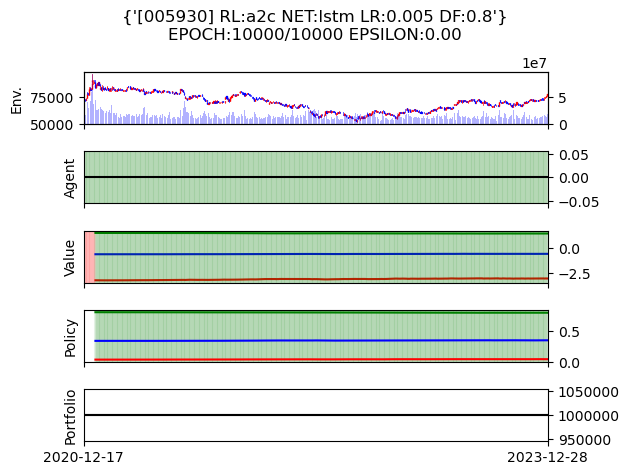

In [89]:
run_trader(stock_names=['삼성전자'], stock_codes=['005930'], net='lstm', rl_method='a2c', num_epochs=10000, market='kr')

In [90]:
run_trader(stock_names=['삼성전자', '현대자동차', 'NAVER'], stock_codes=['005930', '005380', '035420'], net='lstm', rl_method='a3c', num_epochs=1000, market='kr')

 
                        SELECT * FROM price_kr
                        WHERE company_code = '005930'
                        AND date BETWEEN '2020-01-01' AND '2023-12-31' 
                        
 
                        SELECT * FROM price_kr
                        WHERE company_code = '005380'
                        AND date BETWEEN '2020-01-01' AND '2023-12-31' 
                        
 
                        SELECT * FROM price_kr
                        WHERE company_code = '035420'
                        AND date BETWEEN '2020-01-01' AND '2023-12-31' 
                        


  0%|          | 0/1000 [00:00<?, ?it/s]



































































































































































































































































































































  0%|          | 1/1000 [00:05<1:28:49,  5.33s/it]









































































































































































































































































































  0%|          | 2/1000 [00:08<1:11:54,  4.32s/it]













































































































































































































































